<a href="https://colab.research.google.com/github/MadeleineGastonguay/ARC_reactivation_model/blob/main/ARC_reactivation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import pymc as pymc
import pytensor.tensor as pt
import arviz as az
import seaborn as sns
import pandas as pd

# Models for ARC dynamics

By: Alison Hill (Toronto) + Maddie Gastonguay (JHU)



# Model details

## Model descriptions

**Active subpopulation model** (null hypothesis): Out of all the authentic reservoir clones (ARCs), there are some that never express virus (i.e., resting), and others that are always expressing some virus (i.e., active). For simplicity, we assume that all virus-expressing cells expess the same amount of virus. The fraction of expressing ("active") ARCs is $f_a$.


**Transient reactivation model** (alternative hypothesis): We assume that all ARC are capable of reactivating but switch back and forth between being in a activated, virus-exprssing state and being in a dormant, non-expressing state. We assume the switching rates are random and identical across all cells. The rate of switching viral expression "on" ("activation rate") is $a$ and the rate of switching "off" ("deactivation rate" or transition to "resting") is $r$. Under this model the average time an ARC cell stays in a resting state before becoming active would be $1/a$ and the average time an ARC cell stays in an active state before transitioning to resting would be $1/r$. The average fraction of ARC active at any time once the population has equilibrated is $f_a = a/(a+r)$.

In both cases we ignore cellular proliferation as well as CTL killing (or any other source of cell death), for now.

### Equations and code for Transient Reactivation Model

Let $X$ = Number of resting cells, $Y$ = number of active cells

Differential equations (rate of change):

$\frac{dX}{dt} = - a X + r Y $

$\frac{dY}{dt} = a X - r Y $

Solution (time course of active cells):

$Y(t) =  f_a - (f_a  - f) e^{-(r+a)t}$

where $f_a$ is the fraction of active cells at equilibrium:

$ f_ a = a/(a+r)$

And $f$ is the fraction at the beginning of the experiment


In [ ]:
def model(y,t,a,r):
    dy=[0,0]
    dy[0]= - a*y[0] + r*y[1] # latent cells
    dy[1]= a*y[0] - r*y[1] # reactivated cells

    return dy

## Simulations


We simulate the change in the fraction of cells that are actively expressing virus over time, depending on the initial fraction of virus expressing ("active") cells in the population.

We compare an enrichment scenario, in which the initial fraction is much higher than the equilibrium fraction ($f_{up} > f_a$) , and a depletion scenario, in which the initial fraction is lower than the equilibrium fraction ($f_{down} > f_a$).




#### Baseline scenario

For now, we assume the following parameter values:
* Activation rate $a$ = 1/(300 days)
* Deactivation rate is $r$ = 1/(3 days)
* Fraction of virus expressing cells after enrichment, $f_{up}$ = 17%
* Fraction of virus expressing cells after depletion, $f_{down}$ = 0%

In [ ]:
a = 0.003
r = 0.3
fa = a/(a+r)
print("activation rate is a = {:1.3f} per day".format(a))
print("deactivation rate is r = {:1.3f} per day".format(r))
print("equilibrium fraction activated is fa = {:1.3f}".format(fa))

print("average time spent activated is T_a = 1/r = {:3.2f} days".format(1/r))
print("average time spent resting is T_r = 1/a = {:3.2f} days".format(1/a))

activation rate is a = 0.003 per day
deactivation rate is r = 0.300 per day
equilibrium fraction activated is fa = 0.010
average time spent activated is T_a = 1/r = 3.33 days
average time spent resting is T_r = 1/a = 333.33 days


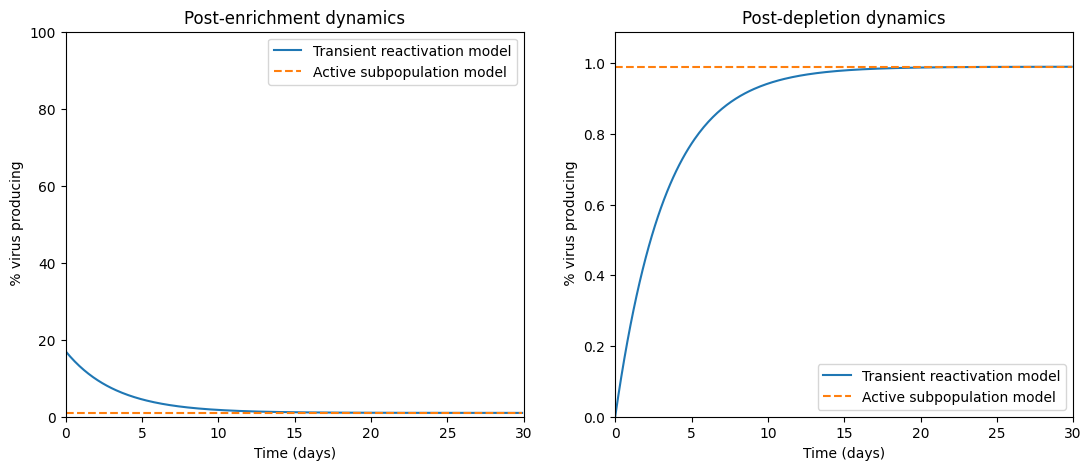

In [ ]:
tmax=30
fup = 0.17
fdown = 0

# enrichment scenario

ic_up=[1-fup,fup]

tvec=np.arange(0,tmax,0.1)

soln_up=odeint(model,ic_up,tvec,args=(a,r))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,100*soln_up[:,1]/(soln_up[:,0]+soln_up[:,1]))
plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--')
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-enrichment dynamics")
plt.ylim([0,100])
plt.xlim([0,tmax])
plt.legend(['Transient reactivation model','Active subpopulation model'])

# depletion scenario

ic_down=[1-fdown,fdown]

tvec=np.arange(0,tmax,0.1)

soln_down=odeint(model,ic_down,tvec,args=(a,r))

plt.subplot(1,2,2)
plt.plot(tvec,100*soln_down[:,1]/(soln_down[:,0]+soln_down[:,1]))
plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--')
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-depletion dynamics")
plt.ylim([0,fa*100*1.1])
plt.xlim([0,tmax])
plt.legend(['Transient reactivation model','Active subpopulation model'])


We examine how the results depend on the values of the parameters (ie, the rates of reactivate and deactivation)

#### Varying the time between reactivation events

(0.0, 30.0)

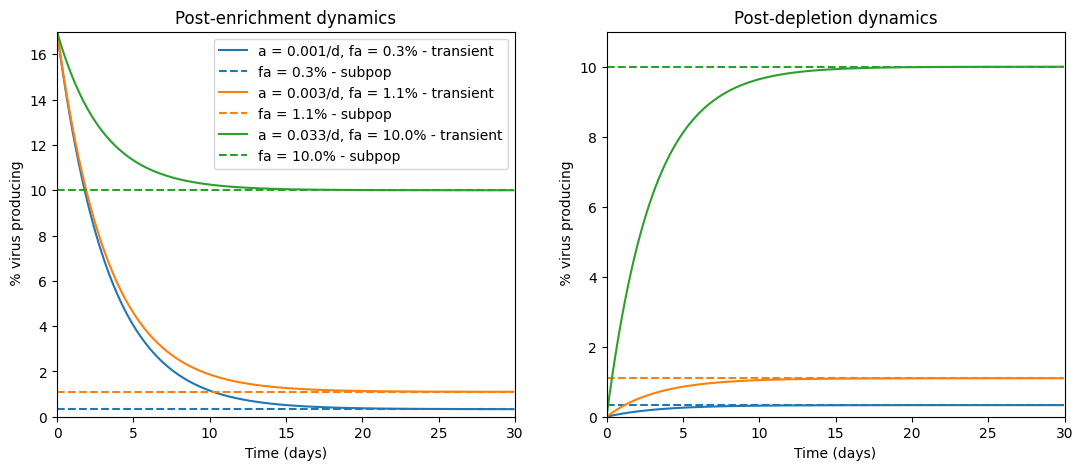

In [ ]:
tmax=30

a_vec = np.array([1/1000,1/300, 1/30])
r = 0.3

fup = 0.17
fdown = 0

ic_up=[1-fup,fup]
ic_down=[1-fdown,fdown]

tvec=np.arange(0,tmax,0.1)

plt.figure(figsize=(13,5))

for a in a_vec:

  fa = a/(a+r)

  # enrichment scenario

  soln_up=odeint(model,ic_up,tvec,args=(a,r))

  plt.subplot(1,2,1)
  plt.plot(tvec,100*soln_up[:,1]/(soln_up[:,0]+soln_up[:,1]),label="a = {:.3f}/d, fa = {:.1f}% - transient".format(a,fa*100))
  last_color = plt.gca().get_lines()[-1].get_color()
  plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--', color = last_color,label="fa = {:.1f}% - subpop".format(fa*100))

  # depletion scenario

  soln_down=odeint(model,ic_down,tvec,args=(a,r))

  plt.subplot(1,2,2)
  plt.plot(tvec,100*soln_down[:,1]/(soln_down[:,0]+soln_down[:,1]))
  plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--',color = last_color)


# plot format

plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-enrichment dynamics")
plt.ylim([0,100*np.max([fa*1.1,fup])])
plt.xlim([0,tmax])
#plt.legend(['Transient reactivation model','Active subpopulation model'])
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-depletion dynamics")
plt.ylim([0,fa*100*1.1])
plt.xlim([0,tmax])


#### Varying the time spent activated

(0.0, 30.0)

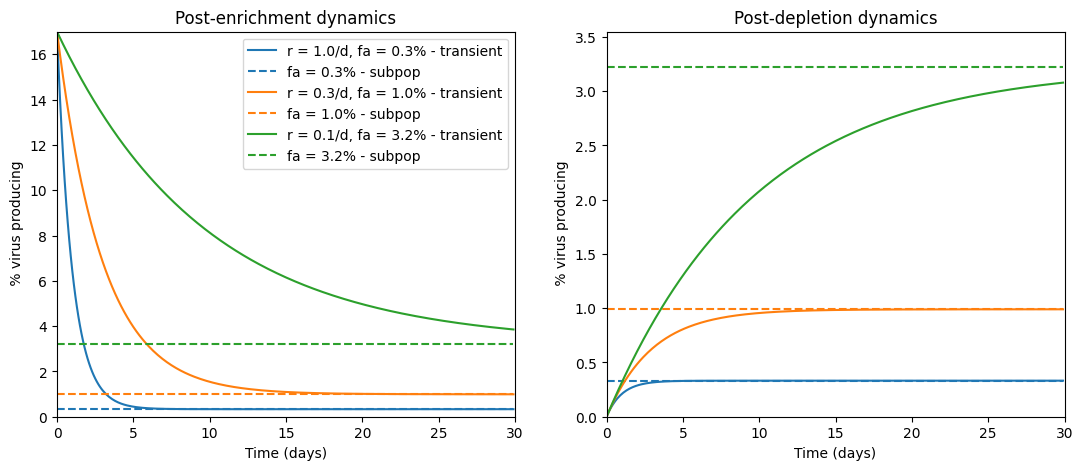

In [ ]:
tmax=30

r_vec = np.array([1/1,1/3, 1/10])
a = 1/300

fup = 0.17
fdown = 0

ic_up=[1-fup,fup]
ic_down=[1-fdown,fdown]

tvec=np.arange(0,tmax,0.1)

plt.figure(figsize=(13,5))

for r in r_vec:

  fa = a/(a+r)

  # enrichment scenario

  soln_up=odeint(model,ic_up,tvec,args=(a,r))

  plt.subplot(1,2,1)
  plt.plot(tvec,100*soln_up[:,1]/(soln_up[:,0]+soln_up[:,1]),label="r = {:.1f}/d, fa = {:.1f}% - transient".format(r,fa*100))
  last_color = plt.gca().get_lines()[-1].get_color()
  plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--', color = last_color,label="fa = {:.1f}% - subpop".format(fa*100))

  # depletion scenario

  soln_down=odeint(model,ic_down,tvec,args=(a,r))

  plt.subplot(1,2,2)
  plt.plot(tvec,100*soln_down[:,1]/(soln_down[:,0]+soln_down[:,1]))
  plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--',color = last_color)


# plot format

plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-enrichment dynamics")
plt.ylim([0,100*np.max([fa*1.1,fup])])
plt.xlim([0,tmax])
#plt.legend(['Transient reactivation model','Active subpopulation model'])
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-depletion dynamics")
plt.ylim([0,fa*100*1.1])
plt.xlim([0,tmax])

#### Varying frequency of reactivation while keeping fraction activated at any point in time the same

(0.0, 30.0)

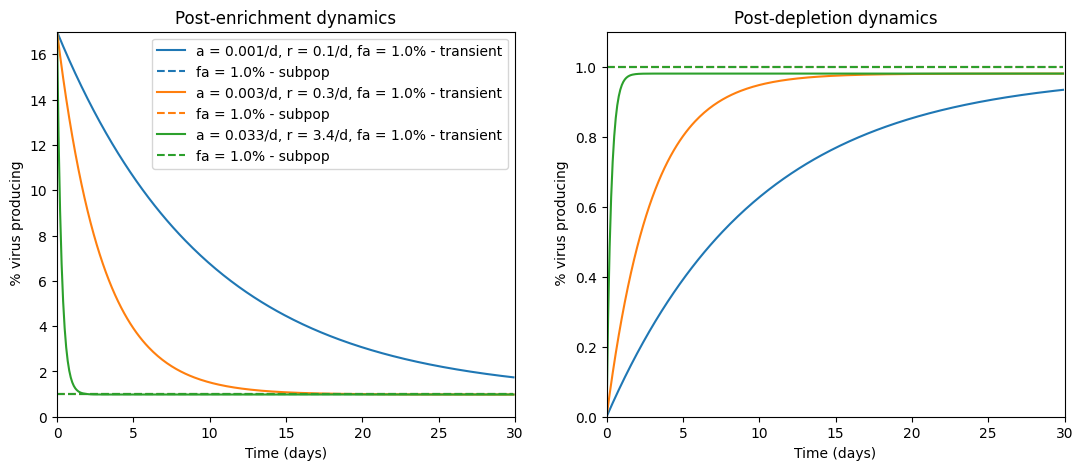

In [ ]:
tmax=30

fa = 0.01
a_vec = np.array([1/1000,1/300, 1/30])

fup = 0.17
fdown = 0

ic_up=[1-fup,fup]
ic_down=[1-fdown,fdown]

tvec=np.arange(0,tmax,0.1)

plt.figure(figsize=(13,5))

for a in a_vec:

  r = a*(1+1/fa)

  # enrichment scenario

  soln_up=odeint(model,ic_up,tvec,args=(a,r))

  plt.subplot(1,2,1)
  plt.plot(tvec,100*soln_up[:,1]/(soln_up[:,0]+soln_up[:,1]),label="a = {:.3f}/d, r = {:.1f}/d, fa = {:.1f}% - transient".format(a,r,fa*100))
  last_color = plt.gca().get_lines()[-1].get_color()
  plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--', color = last_color,label="fa = {:.1f}% - subpop".format(fa*100))

  # depletion scenario

  soln_down=odeint(model,ic_down,tvec,args=(a,r))

  plt.subplot(1,2,2)
  plt.plot(tvec,100*soln_down[:,1]/(soln_down[:,0]+soln_down[:,1]))
  plt.plot(tvec,100*fa*np.ones(np.shape(tvec)),'--',color = last_color)


# plot format

plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-enrichment dynamics")
plt.ylim([0,100*np.max([fa*1.1,fup])])
plt.xlim([0,tmax])
#plt.legend(['Transient reactivation model','Active subpopulation model'])
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Post-depletion dynamics")
plt.ylim([0,fa*100*1.1])
plt.xlim([0,tmax])


### Summary of findings

Under the transient activation model, the % of virus-producing cells returns to the baseline level after enrichment or depletion. The baseline level of activation is determined by the average fraction of time cells spend in an acitvated state ($f_a = a/(a+r)$ = $T_a/(T_a+T_r)$). Since we observe $f_a \sim 1\%$, the suggests that $a \sim 0.01 r$ (formal fitting to follow).

The curve determining the dynamics post-perturbation is

$Y(t) =  f_a - (f_a  - f) e^{-(r+a)t}$

(where $f_a$ is baseline \% activated and $f$ is the post-perturbation value)

which gives the following results:
* the timescale of the rate of return to baseline is determined by $r+a$ for **both** the enrichment and depletion scenario. This time is roughly the time until levels are half-way back to baseline. Because the low \% activation suggests $a <<< r$, the time to recovery is determined mainly by r. In general it's the faster of the rates that determines the revovery time.
* post-depletion, the initial approximately linear rate of recovery before saturation is $\sim a$, so it varies with the activation rate only
* post-enrichment, the initial approximately linear rate of recovery before saturation is $\sim r$, so it varies mainly with the deactivation rate only. (Note: it's actually $r * [1-f_a*(1-f)/(1-f_a)]$ which for relatively small $f_a$ and $f$ is $\sim r$)



# Fitting to data

### Description of fitting approach

Function we are fitting to data:

$Y(t) =  f_a - (f_a  - f) e^{-(r+a)t}$

where $f_a$ is the fraction of active cells at equilibrium:

$ f_ a = a/(a+r)$

And $f$ is the fraction at the beginning of the experiment.

We assume:
- sampling error is negligble due to large cell counts
- variation between replicates can be described with a normal distribution with standard deviation proportional to mean ($\sigma = cv*\mu$ where $cv$ is the coefficient of variation)
- $a$ and $r$ are the same between experiments
- $f$ differs between experiments, and we treat it as an unknown since our measurement error model applies to it

We are sampling:
- $s^{-1}$, where $s = a+r$, from a Half-normal distribution with sigma = 5
- $log(f_a)$, the fraction at equilibrium ($f_a = a/s$) from a normal distribution with mean $log(10^-3)$ and standard deviation 1
- $\eta_d$, the percent activated relative to steady state fraction of activated cells at the start of the depletion experiment, sampled from $Gamma(1,5)$
- $v$, a factor used to calculate $\eta_e$ so that it remains bounded bewteen 1 and 1/fa, sampled from $Beta(1,1)$
- $cv$, the coefficient of variation of measurement error from $Gamma(1,3)$

We can calcualte:
- $\eta_e$, the percent activated relative to steady state fraction of activated cells in the depletion experiment as $1+v*(1/f_a-1)$
- $f_e$, the initial fraction from the enhancement experiment as $\eta_e*f_a$
- $f_d$, the intial fraction from the depletion experiment as $\eta_d*f_a$
- $a = f_a*s$, the rate at which latent cells activate
- $r = s-a$, the rate at which active cells stop expressing HIV


Below, we evaluate our model fitting approach in simulated data before applying it separately to data from ARC Ch16 and ZNF721.




### Evaluating model fitting in simulated data

To evaluate the accuracy of our model fitting approach, we applied it to simulated data with a smiliar design to the available experimental data. We assume the fraction of activated cells are measured in triplicate at day 0, 5, and 10, and that experimental data are measured with a 10% coefficient of variation due to measurement noise. Data for the depletion scenario are simulated with $r = 1/3$, $a = 1/300$, $f_a = 0.01$, and $f = 0.005$.

In [7]:
## Generate Simulated data
# assume that r = 1/3 and a = 1/300 and initial fraction (f) = 0.005
n = 3 # 3 replicates
r = 1/3
a = 1/300
s = a+r
fa = a/s
f = 0.005
coefvar = 0.1

# Simulated fraction activated over time
day = np.array([0,5, 10])
y = fa - (fa-f)*np.exp(-s*day)

# Add measurement noise for each replicate
sim_data = np.empty((len(day), n))

for i in range(n):
    for j in range(len(day)):
        sim_data[j, i] = np.random.normal(loc=y[j], scale=coefvar * y[j])

In [8]:
# Fit model
with pymc.Model() as latency_model:

  # Priors
  fa = pymc.Beta("fa", alpha = 0.5, beta = 0.5) # Jeffery's prior for binomial distribution
  eta = pymc.Gamma("eta", alpha = 1, beta = 5) # Prior for percent enrichment
  s_inv = pymc.HalfNormal("s_inv", sigma = 5) # Prior for 1/(r+a)
  cv = pymc.Gamma("cv",  alpha = 1, beta = 1) # Prior for measurement noise CV

  # Calculated parameters for reporting out
  s = pymc.Deterministic("s", 1/s_inv)
  a = pymc.Deterministic("a", fa*s)
  r = pymc.Deterministic("r", s-a)
  f = pymc.Deterministic("f", eta*fa)

  # Calculate expected fraction activated at this time
  exp_frac = pymc.Deterministic("exp_frac", fa - (fa-f)*pymc.math.exp(-s*day))

  # Expand to match 4 × 100 observed matrix
  mu = exp_frac[:, None]
  sigma = (cv * exp_frac)[:, None]

  # Likelihood
  obs = pymc.Normal("obs", mu = mu, sigma = sigma, observed = sim_data)

  # Sample posterior
  trace = pymc.sample(2000, target_accept=0.99)
  # trace = pymc.sample(2000, target_accept=0.9)

Output()

#### Prior Predictive check
The prior predictive check shows a range of plausible curves for activated cells over time, indicating the priors are not constricting parameter inference.

/tmp/ipython-input-3083238873.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


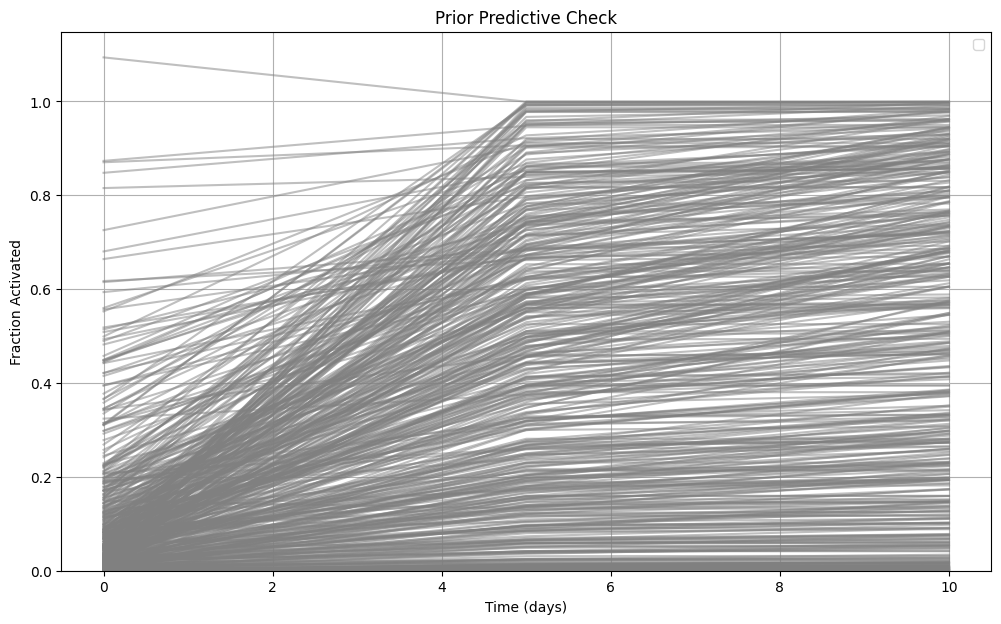

In [9]:
# Sample from prior distributions
with latency_model:
  idata = pymc.sample_prior_predictive(draws=500)

plt.figure(figsize=(12, 7))

prior = idata.prior["exp_frac"]

# Plot individual processed replicates as lines
num_replicates = prior.shape[1]
for j in range(num_replicates):
    plt.plot(day, prior[0, j, :], color='grey', alpha=0.5)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title("Prior Predictive Check")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()

#### Posterior Distributions
The posterior distributions from both chains converged:

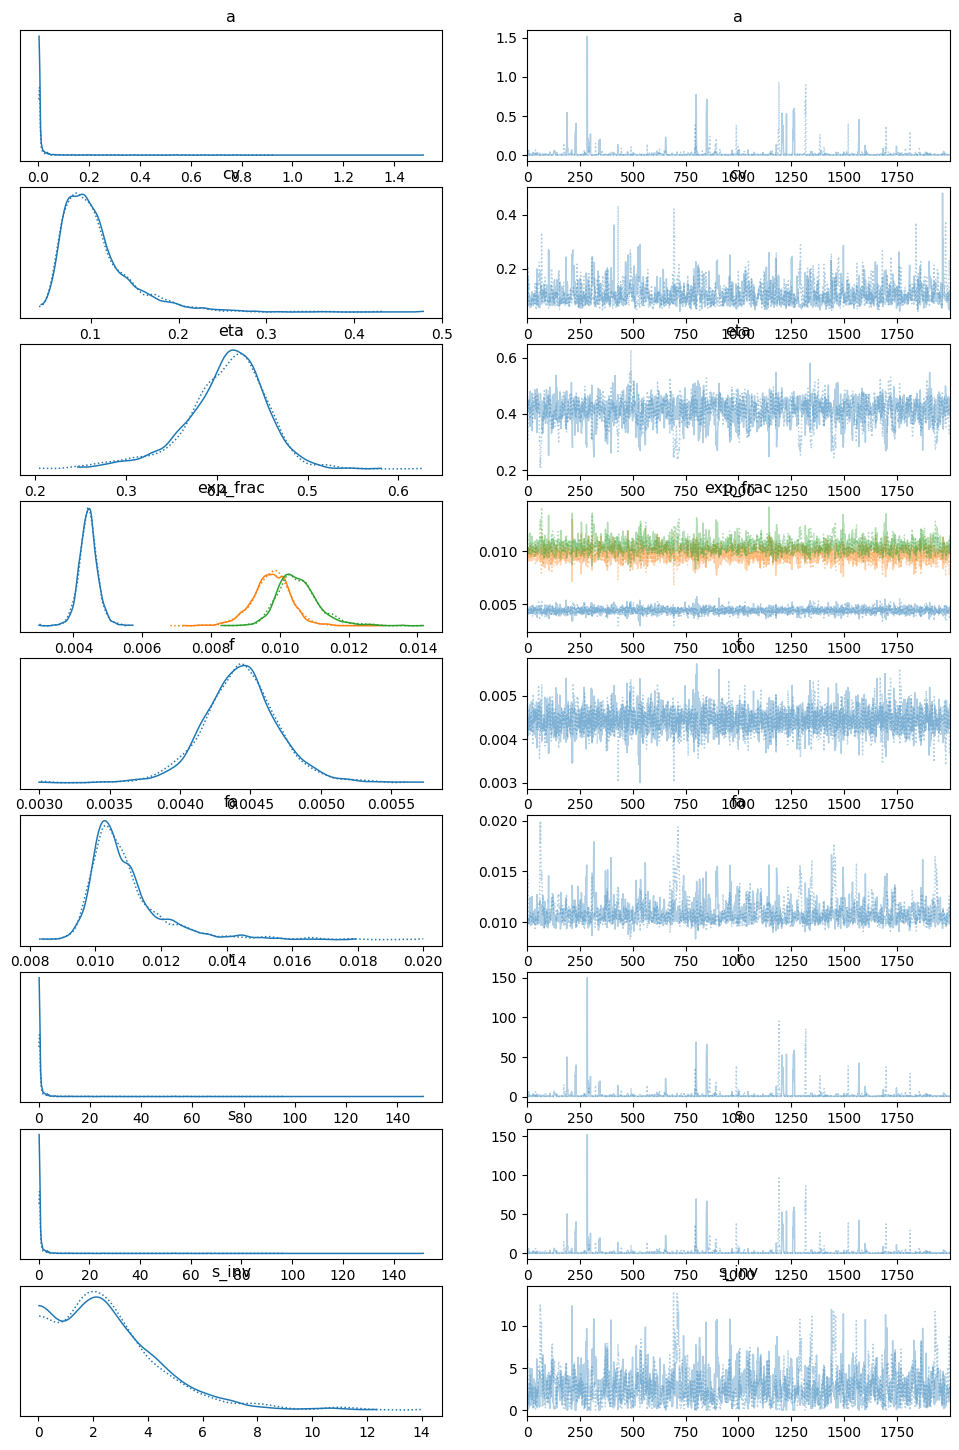

In [10]:
az.plot_trace(trace);

In [11]:
# Parameter Estimates
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a            0.015  0.060   0.001    0.036      0.002    0.009     651.0   
cv           0.106  0.040   0.050    0.179      0.001    0.002     827.0   
eta          0.410  0.045   0.318    0.491      0.002    0.002     742.0   
exp_frac[0]  0.004  0.000   0.004    0.005      0.000    0.000    2626.0   
exp_frac[1]  0.010  0.001   0.009    0.011      0.000    0.000    1780.0   
exp_frac[2]  0.011  0.001   0.009    0.012      0.000    0.000     938.0   
f            0.004  0.000   0.004    0.005      0.000    0.000    2626.0   
fa           0.011  0.001   0.009    0.013      0.000    0.000     685.0   
r            1.487  5.832   0.070    3.484      0.188    0.864     608.0   
s            1.502  5.891   0.071    3.519      0.190    0.873     608.0   
s_inv        2.680  1.969   0.010    5.995      0.085    0.091     608.0   

             ess_tail  r_hat  
a               848.0    1.0  
cv             1369.0    1.0  
eta             449.0    1.0  
exp_frac[0]    2279.0    1.0  
exp_frac[1]    2216.0    1.0  
exp_frac[2]     949.0    1.0  
f              2279.0    1.0  
fa              508.0    1.0  
r               706.0    1.0  
s               706.0    1.0  
s_inv           706.0    1.0

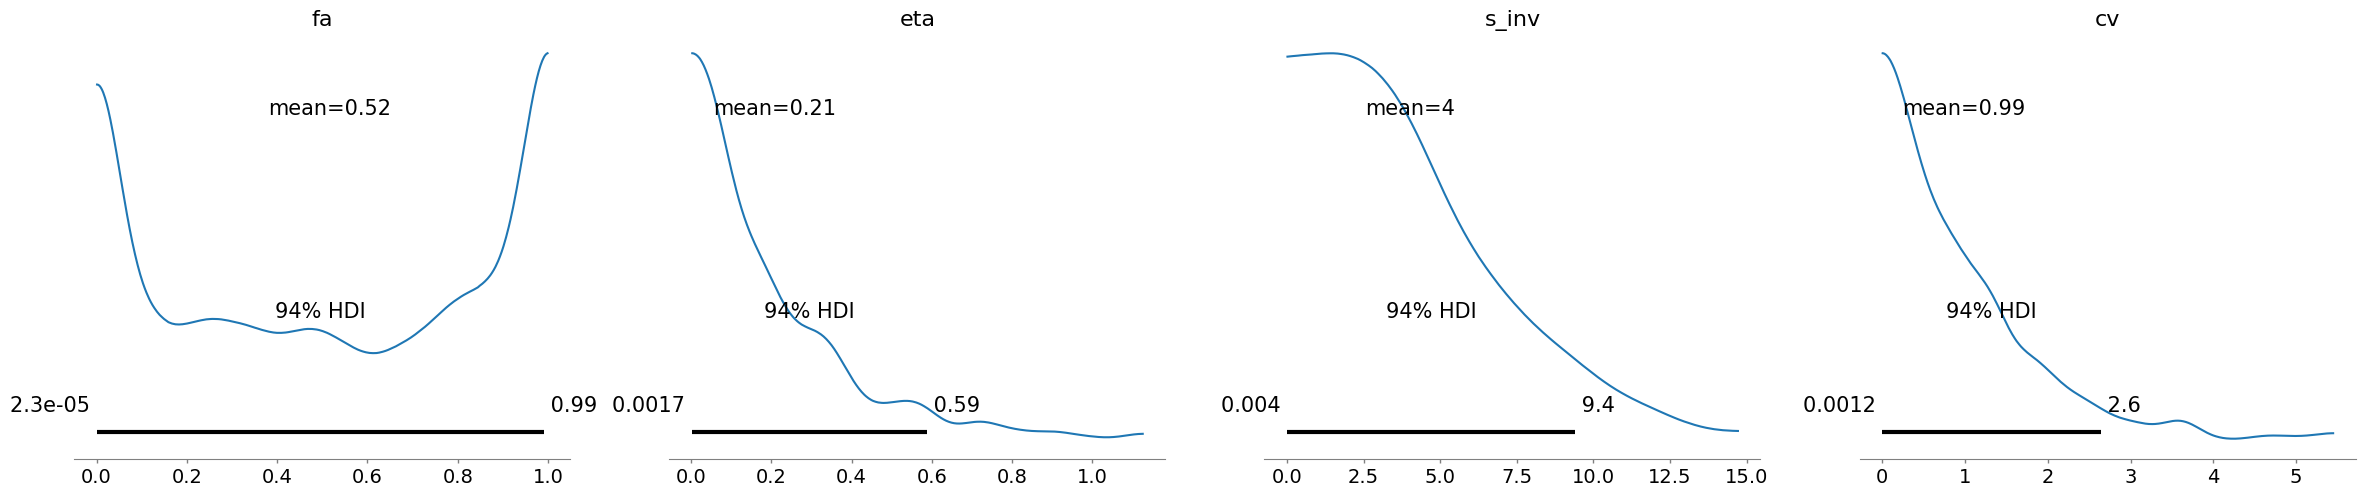

In [12]:
az.plot_posterior(idata, var_names=['fa', 'eta', 's_inv', 'cv'], group = "prior");

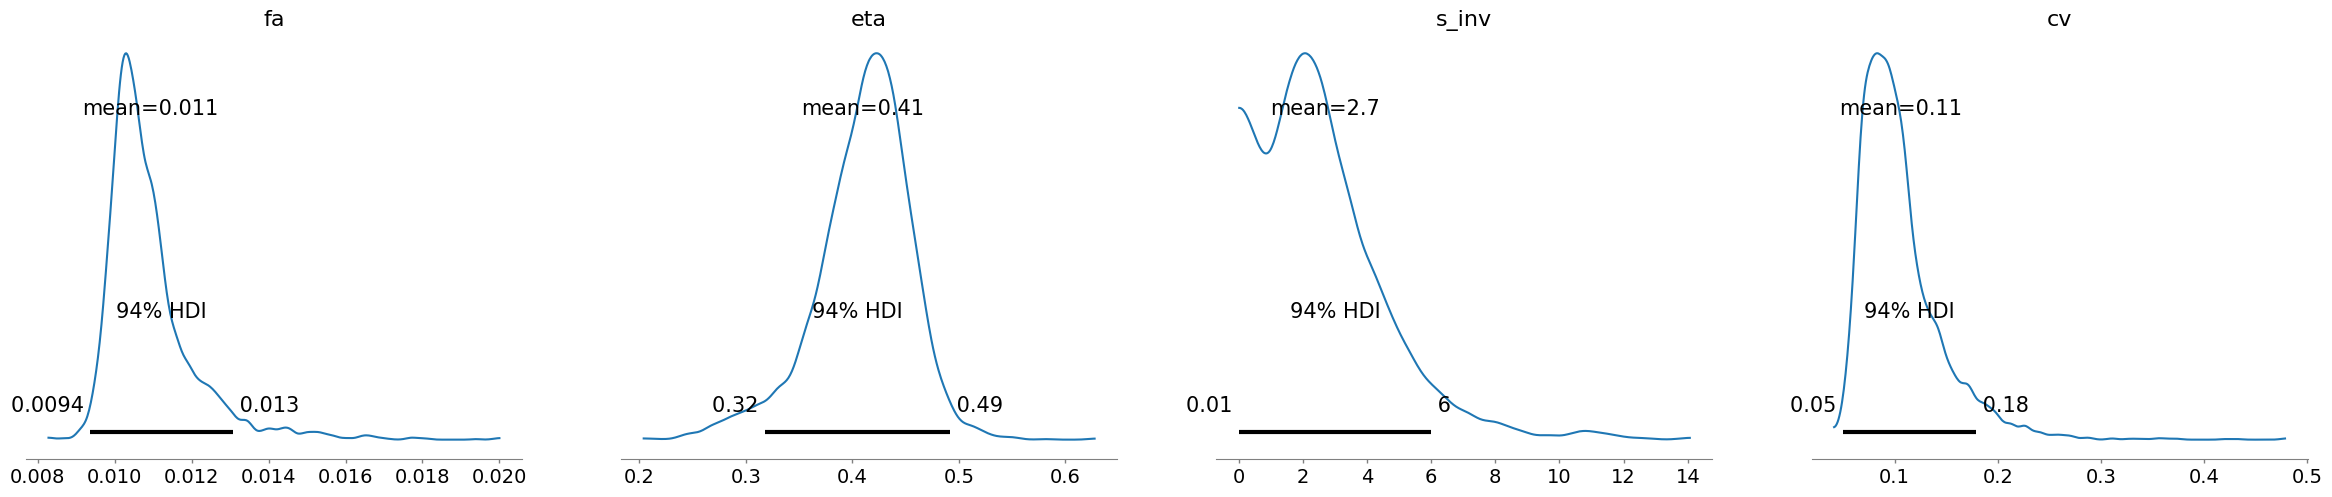

In [13]:
az.plot_posterior(trace, var_names=['fa', 'eta', 's_inv', 'cv']);

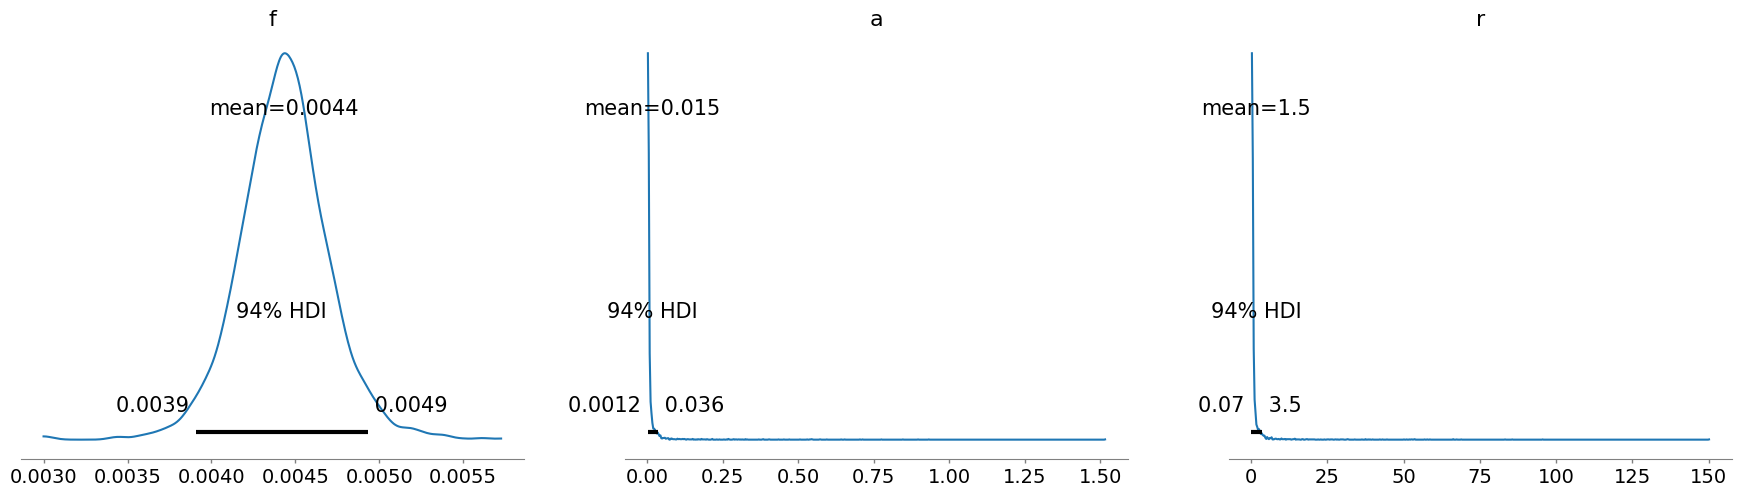

In [14]:
az.plot_posterior(trace, var_names=['f', 'a', 'r']);

#### Posteiror predictive check

The posterior predictive check shows that the model accurately captures the trend observed in experimental data.

In [15]:
# Posterior predictive check:
with latency_model:
    trace.extend(pymc.sample_posterior_predictive(trace))

Output()

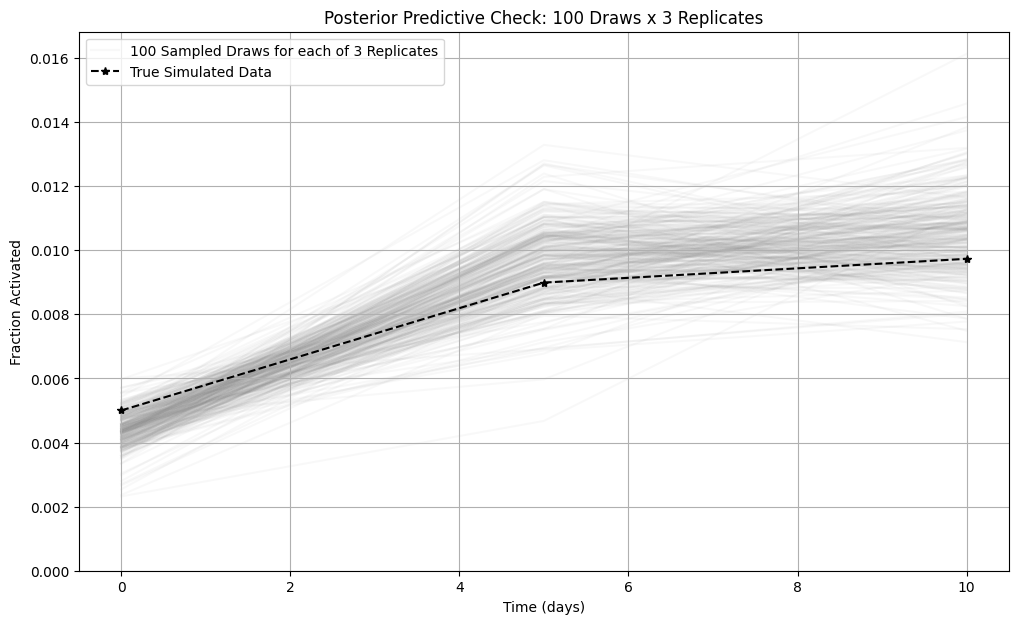

In [16]:
# Get posterior predictive samples
ppc = trace.posterior_predictive["obs"]

# 1. Filter to just one chain (e.g., the first chain at index 0)
one_chain_ppc = ppc.values[0, :, :, :] # Shape (num_draws, num_time_points, num_replicates)

num_draws_total = one_chain_ppc.shape[0]
num_time_points = one_chain_ppc.shape[1]
num_replicates = one_chain_ppc.shape[2]

# 2. Take 100 random samples from the posterior draws
num_samples_to_plot = 100
np.random.seed(42) # For reproducibility of random draws
random_draw_indices = np.random.choice(num_draws_total, size=num_samples_to_plot, replace=False)
selected_draws = one_chain_ppc[random_draw_indices, :, :] # Shape (50, 4, 100)

plt.figure(figsize=(12, 7))

# Plot individual posterior predictive samples as lines
first_plot_line = True
for i in range(num_samples_to_plot): # Iterate over the 50 selected draws
    for j in range(num_replicates):  # Iterate over the 100 replicates
        if first_plot_line:
            plt.plot(day, selected_draws[i, :, j], color='grey', alpha=0.05, label=f'{num_samples_to_plot} Sampled Draws for each of {num_replicates} Replicates', zorder=1)
            first_plot_line = False
        else:
            plt.plot(day, selected_draws[i, :, j], color='grey', alpha=0.05, zorder=1)

# Overlay the 'true' simulated data (y) for comparison
plt.plot(day, y, color='black', marker='*', linestyle='--', label='True Simulated Data', zorder=3)

mean_processed_ppc = one_chain_ppc.mean(axis=1)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title(f"Posterior Predictive Check: {num_samples_to_plot} Draws x {num_replicates} Replicates")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


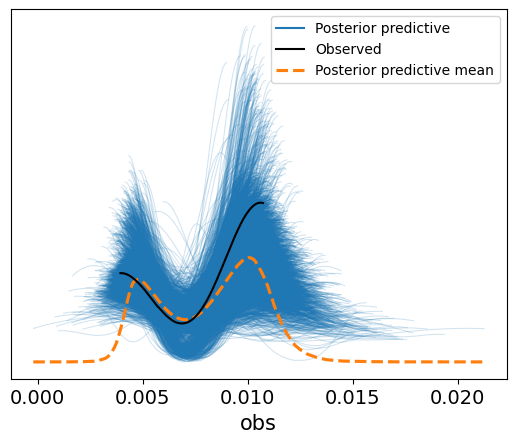

In [17]:
fig, ax = plt.subplots()
az.plot_ppc(trace, ax=ax)
ax.legend(fontsize=10);

## ARC Ch16
Using the approach described above, we fit the model to longitudinal data on the % HIV-Gag
expressing cells from two experimental replicates under the baseline, enrichment, and depletion
conditions under anti-CD3/CD28 stimulation.

### Fit to enrichement & depletion experiments simultaneously

In [18]:
# Experimental Data
day = np.array([0,5, 10, 1000])

# Depletion study
obs_data = np.zeros((len(day), 2))
obs_data[:,0] = [0.08, 0.33, 0.16, 0.45]
obs_data[:,1] = [0.1, 0.33, 0.36, 0.39]
obs_data_deplete = obs_data/100

# Enrichment study
obs_data = np.zeros((len(day), 1))
obs_data[:,0] = [17.8, 3.51, 0.59, 0.45]
obs_data_enrich= obs_data/100

# Missing day 0 for the second replicate in the enrichment experiment
# If we treat it as missing data, it becomes another latent variable to sample, which complicates the inference
# Instead, we will just fit to the available data
day_short = day[1:]
obs_data_enrich_short = np.zeros((len(day_short), 1))
obs_data_enrich_short[:,0] = [4.2/100, 1.07/100, 0.39/100]


In [19]:
# Model
with pymc.Model() as latency_model:

  # Priors
  log_fa = pymc.Normal("log_fa", mu = np.log(1e-3), sigma = 1)
  s_inv = pymc.HalfNormal("s_inv", sigma = 10)
  cv = pymc.Gamma("cv",  alpha = 1, beta = 3)
  eta_d = pymc.Gamma("eta_d", alpha = 1, beta = 5)
  v1 = pymc.Beta("v1", alpha = 1, beta = 1)

  # Calculated parameters for reporting out
  fa = pymc.Deterministic("fa", np.exp(log_fa))
  eta_e = pymc.Deterministic("eta_e", 1+v1*(1/fa-1))
  f_e = pymc.Deterministic("f_e", eta_e*fa)
  f_d = pymc.Deterministic("f_d", eta_d*fa)
  s = pymc.Deterministic("s", 1/s_inv)
  a = pymc.Deterministic("a", fa*s)
  r = pymc.Deterministic("r", s-a)

  # Calculate expected fraction activated at this time
  exp_frac_deplete = pymc.Deterministic("exp_frac_deplete", fa - (fa-f_d)*pymc.math.exp(-s*day)) # Will report out in posterior
  exp_frac_enrich  = pymc.Deterministic("exp_frac_enrich", fa - (fa-f_e)*pymc.math.exp(-s*day)) # Will report out in posterior

  # exp_frac_deplete = fa - (fa-f_d)*pymc.math.exp(-s*day)
  # exp_frac_enirch = fa - (fa-f_e)*pymc.math.exp(-s*day)

  # Expand to match 4 × 100 observed matrix
  mu_d = exp_frac_deplete[:, None]
  sigma_d = (cv * exp_frac_deplete)[:, None]

  mu_e = exp_frac_enrich[:, None]
  sigma_e = (cv * exp_frac_enrich)[:, None]

  mu_e_short = exp_frac_enrich[1:, None]
  sigma_e_short = (cv * exp_frac_enrich)[1:, None]

  # Likelihood
  obs_d = pymc.Normal("obs_d", mu = mu_d, sigma = sigma_d, observed = obs_data_deplete) # depletion experiment
  obs_e = pymc.Normal("obs_e", mu = mu_e, sigma = sigma_e, observed = obs_data_enrich) # enrichment experiment with all time points
  obs_e_short = pymc.Normal("obs_e_short", mu = mu_e_short, sigma = sigma_e_short, observed = obs_data_enrich_short) # enrichment experiment without first time


  # Sample posterior
  trace = pymc.sample(2000, target_accept=0.9)

Output()

#### Prior predictive check
Sample from the prior to make sure the possible trajectories are reasonable

/tmp/ipython-input-2869518935.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


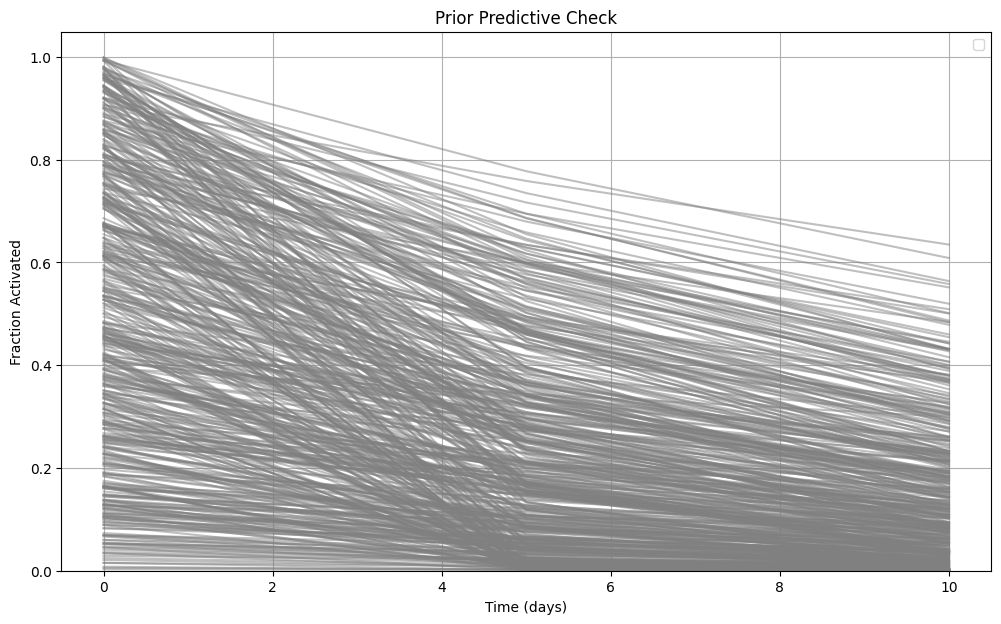

In [20]:
with latency_model:
  idata = pymc.sample_prior_predictive(draws=500)

plt.figure(figsize=(12, 7))

prior = idata.prior["exp_frac_enrich"]

# Plot individual processed replicates as lines
num_replicates = prior.shape[1]
for j in range(num_replicates):
    plt.plot(day[0:3], prior[0, j, 0:3], color='grey', alpha=0.5)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title("Prior Predictive Check")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()

#### Posterior distributions


In [21]:
chr16_summary = az.summary(trace, round_to = "none", var_names = ["a", "r", "fa", "cv", "f_e", "f_d", "s"], hdi_prob = 0.95)
chr16_summary

mean        sd  hdi_2.5%  hdi_97.5%  mcse_mean   mcse_sd  \
a    0.001297  0.000206  0.000932   0.001735   0.000004  0.000006   
r    0.351048  0.045312  0.254732   0.437689   0.001094  0.001122   
fa   0.003683  0.000339  0.003040   0.004370   0.000007  0.000007   
cv   0.259773  0.065004  0.155743   0.386709   0.001564  0.001898   
f_e  0.198541  0.058661  0.115221   0.315187   0.001619  0.003225   
f_d  0.000894  0.000161  0.000595   0.001207   0.000003  0.000004   
s    0.352345  0.045477  0.255631   0.439345   0.001098  0.001126   

        ess_bulk     ess_tail     r_hat  
a    2151.615666  2232.739023  1.000074  
r    1813.489720  1655.774673  1.001104  
fa   2237.067025  1831.330901  0.999580  
cv   1940.154269  2172.586958  1.000146  
f_e  1918.487888  1132.050715  1.000827  
f_d  2927.210342  2192.849418  1.000297  
s    1813.401624  1655.774673  1.001095

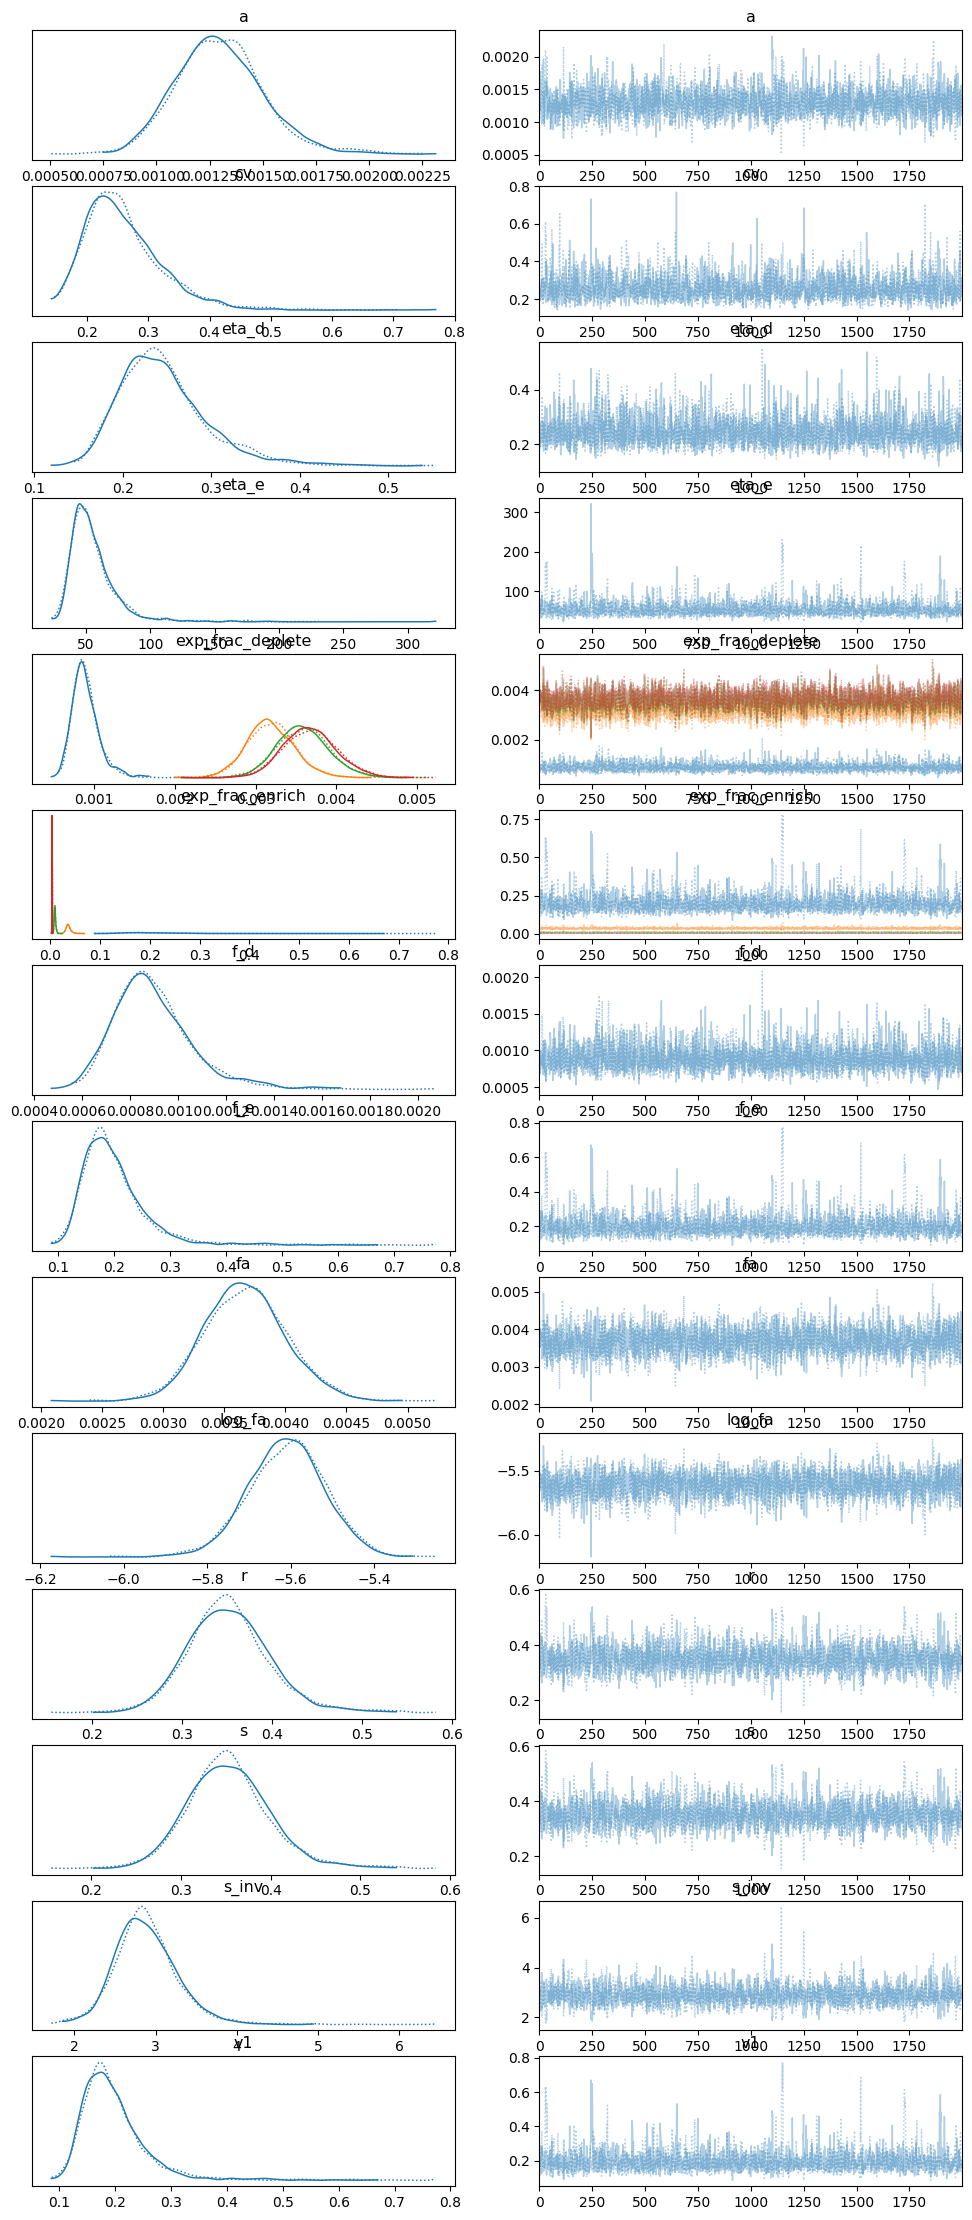

In [ ]:
az.plot_trace(trace);

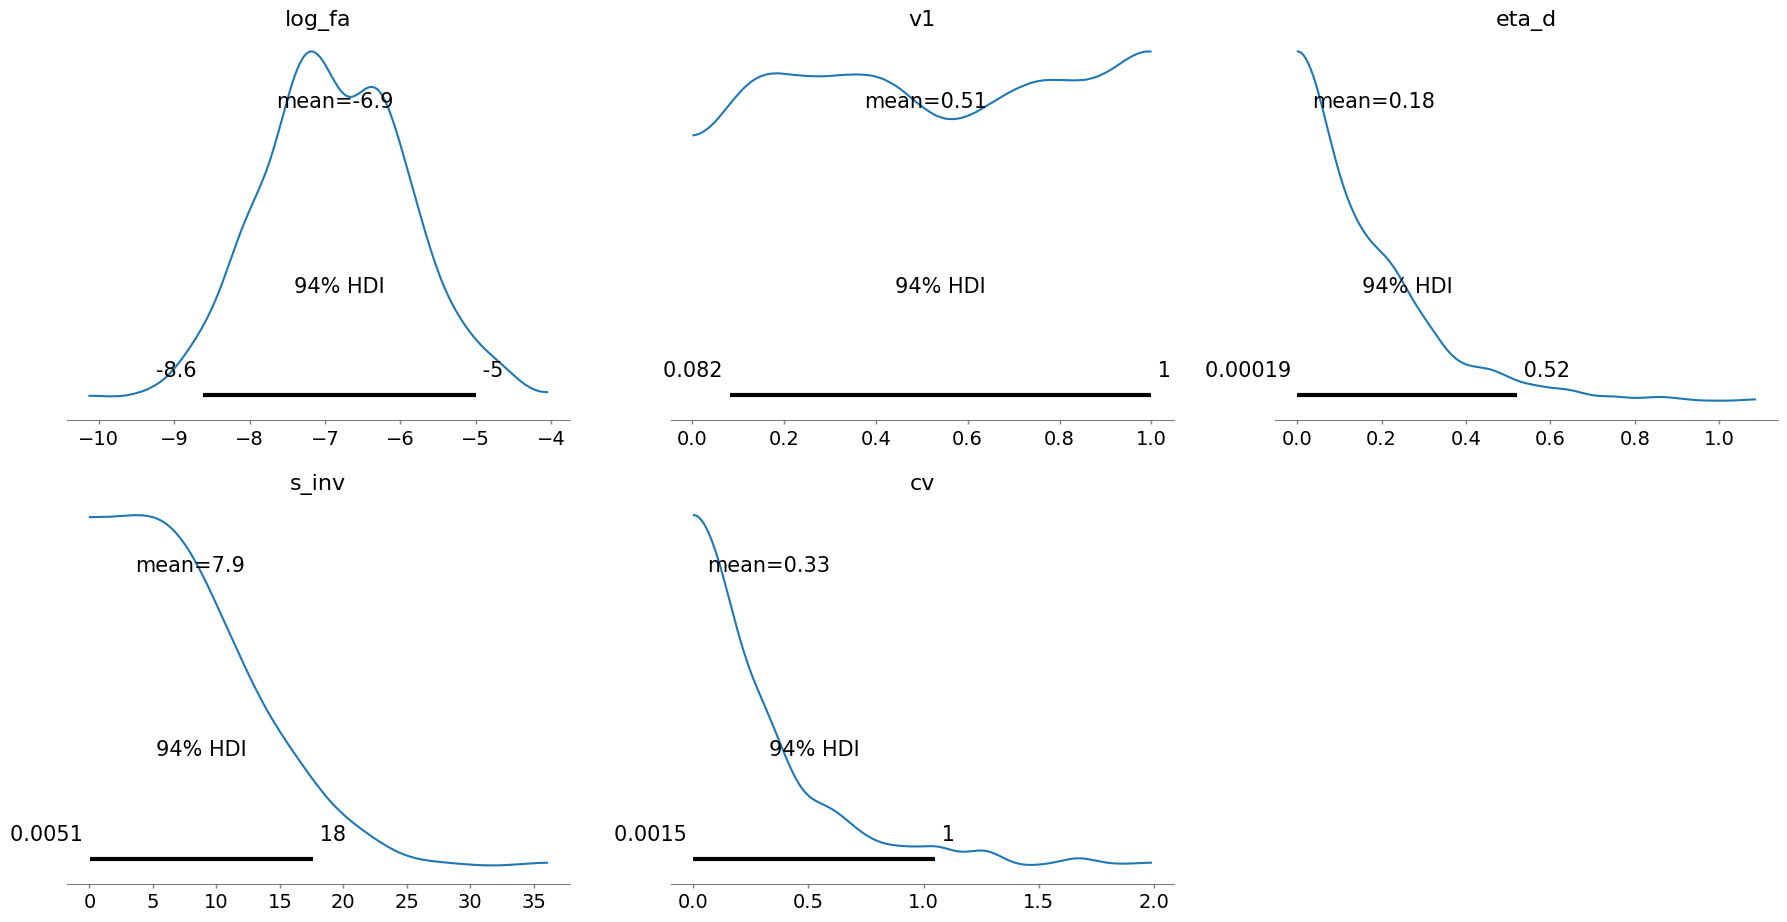

In [22]:
az.plot_posterior(idata, var_names=['log_fa', 'v1', 'eta_d', 's_inv', 'cv'], group = "prior");

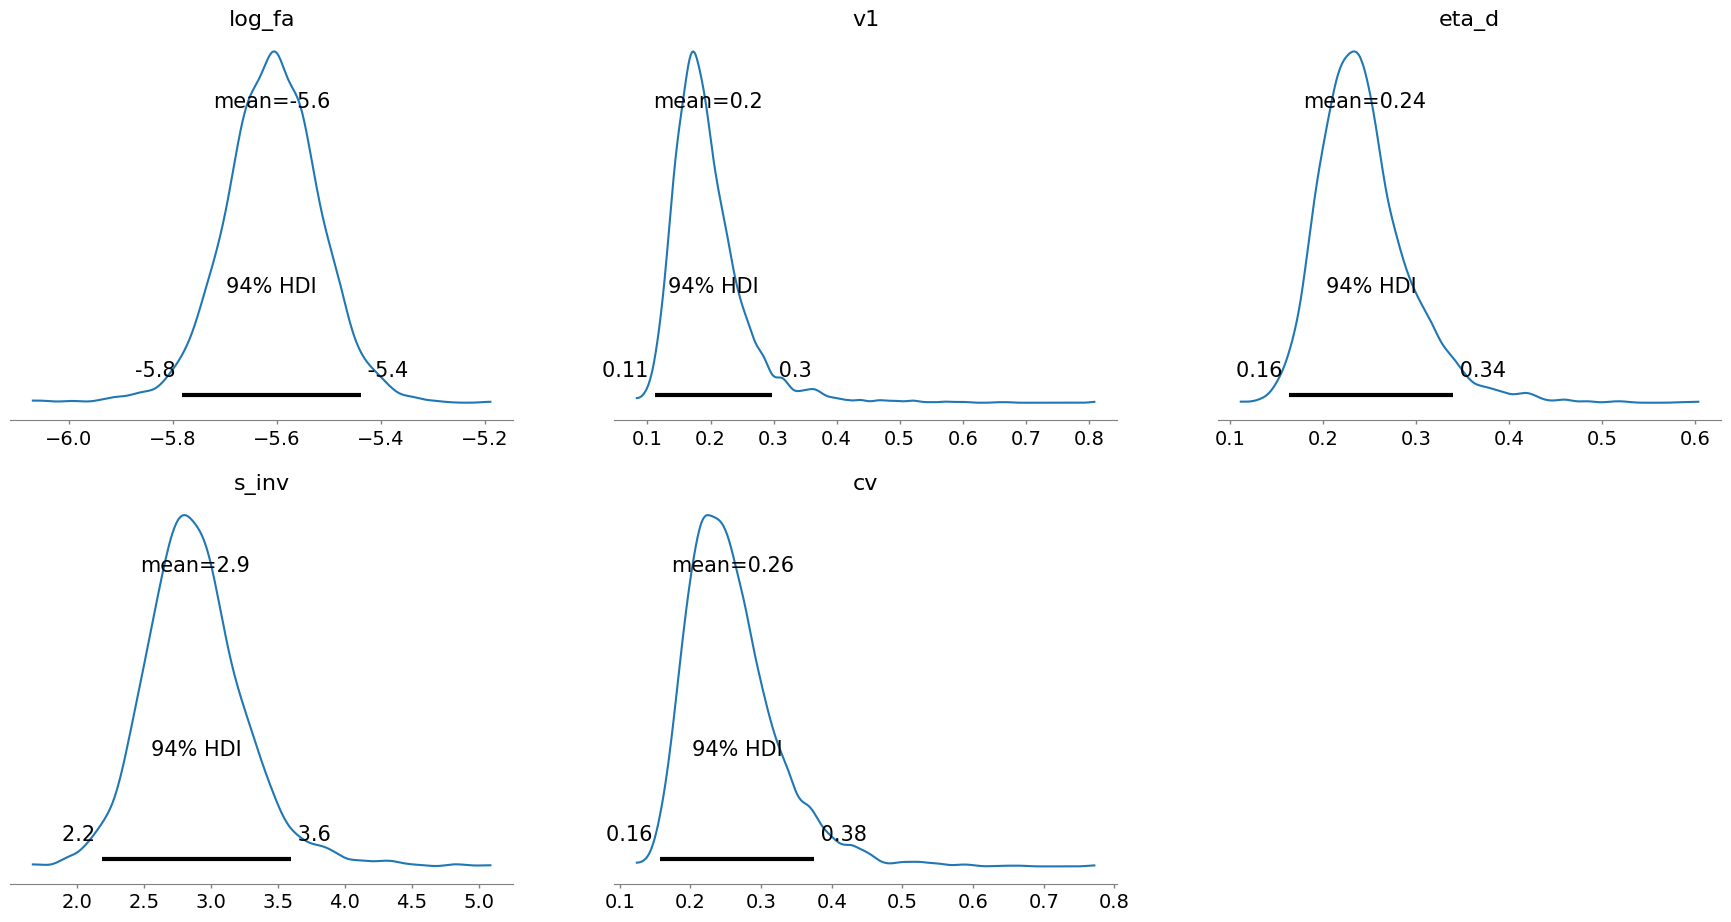

In [23]:
az.plot_posterior(trace, var_names=['log_fa', 'v1', 'eta_d', 's_inv', 'cv'], group = "posterior");

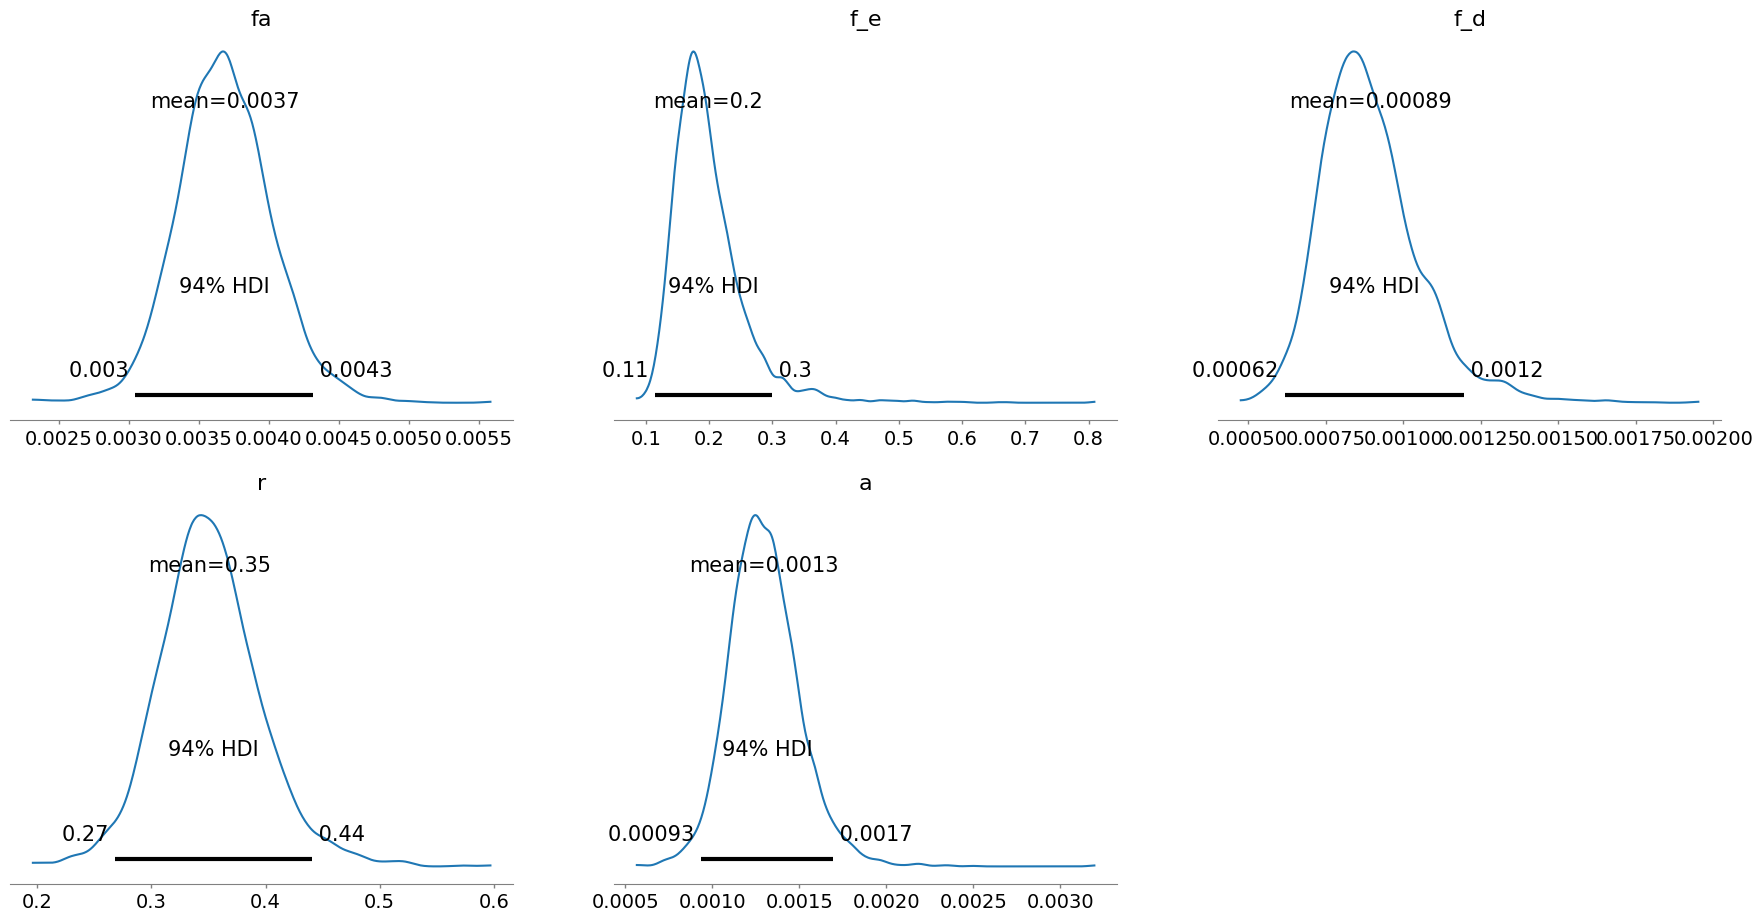

In [24]:
az.plot_posterior(trace, var_names=['fa', 'f_e', 'f_d', 'r', 'a'], group = "posterior");

#### Posterior predictive check

In [25]:
# Posterior predictive check:
with latency_model:
    trace.extend(pymc.sample_posterior_predictive(trace))

Output()

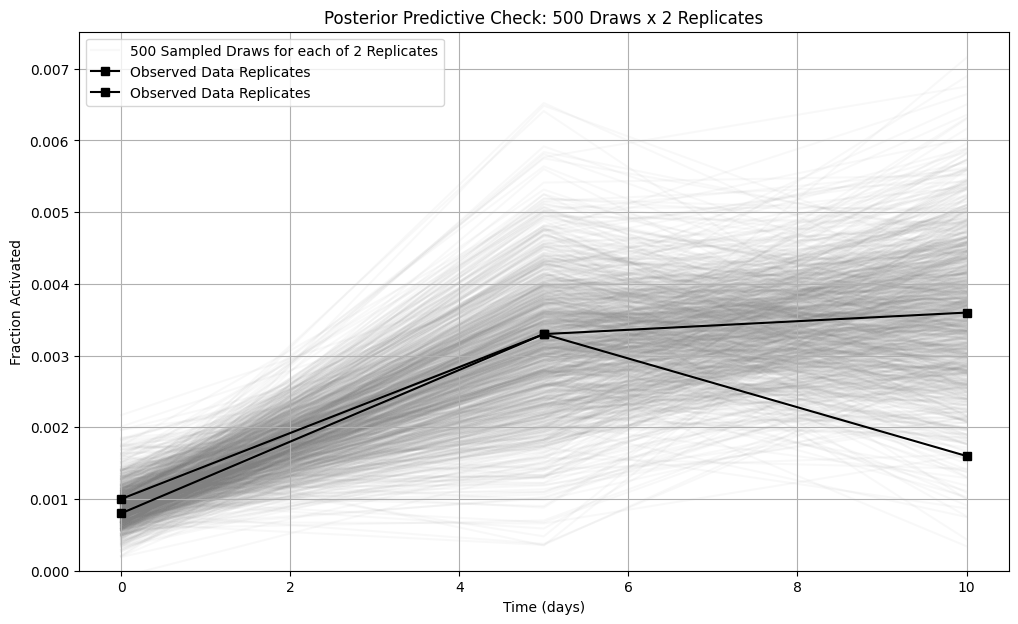

In [26]:
# Get posterior predictive samples
ppc = trace.posterior_predictive["obs_d"]

# 1. Filter to just one chain (e.g., the first chain at index 0)
one_chain_ppc = ppc.values[0, :, :, :] # Shape (num_draws, num_time_points, num_replicates)

num_draws_total = one_chain_ppc.shape[0]
num_time_points = one_chain_ppc.shape[1]
num_replicates = one_chain_ppc.shape[2]

# 2. Take 500 random samples from the posterior draws
num_samples_to_plot = 500
np.random.seed(42) # For reproducibility of random draws
random_draw_indices = np.random.choice(num_draws_total, size=num_samples_to_plot, replace=False)
selected_draws = one_chain_ppc[random_draw_indices, :, :] # Shape (50, 4, 100)

plt.figure(figsize=(12, 7))

# Plot individual posterior predictive samples as lines
first_plot_line = True
for i in range(num_samples_to_plot): # Iterate over the 50 selected draws
    for j in range(num_replicates):  # Iterate over the 100 replicates
        if first_plot_line:
            plt.plot(day[:(len(day)-1)], selected_draws[i, :(len(day)-1), j], color='grey', alpha=0.05, label=f'{num_samples_to_plot} Sampled Draws for each of {num_replicates} Replicates', zorder=1)
            first_plot_line = False
        else:
            plt.plot(day[:(len(day)-1)], selected_draws[i, :(len(day)-1), j], color='grey', alpha=0.05, zorder=1)

# Plot the observed data
plt.plot(day[:(len(day)-1)], obs_data_deplete[:(len(day)-1), :], color='black', marker='s', linestyle='-', label='Observed Data Replicates', zorder=4)


mean_processed_ppc = one_chain_ppc.mean(axis=1)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title(f"Posterior Predictive Check: {num_samples_to_plot} Draws x {num_replicates} Replicates")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()


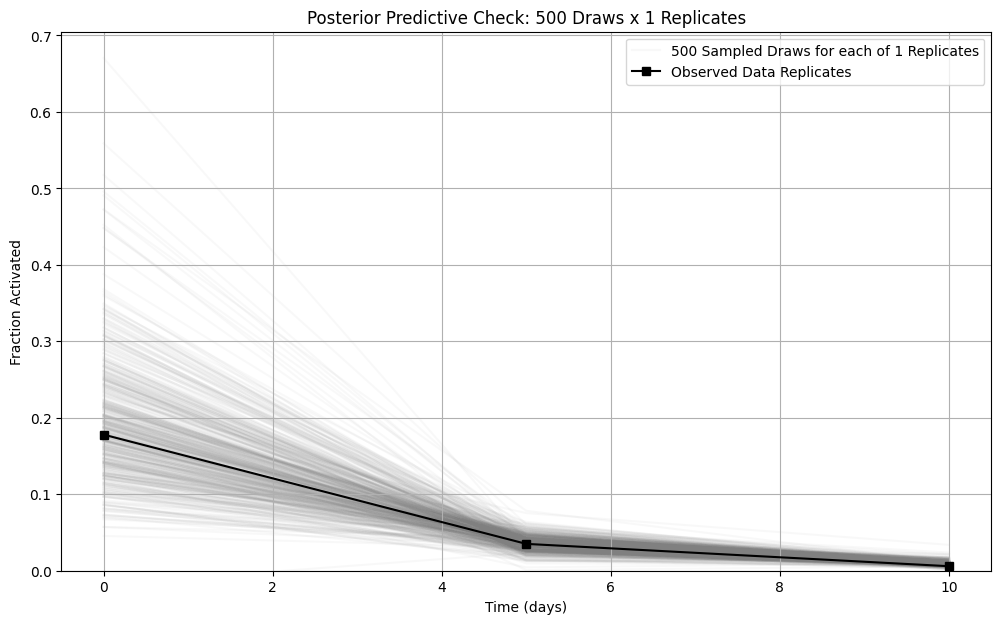

In [27]:
# Get posterior predictive samples
ppc = trace.posterior_predictive["obs_e"]

# 1. Filter to just one chain (e.g., the first chain at index 0)
one_chain_ppc = ppc.values[0, :, :, :] # Shape (num_draws, num_time_points, num_replicates)

num_draws_total = one_chain_ppc.shape[0]
num_time_points = one_chain_ppc.shape[1]
num_replicates = one_chain_ppc.shape[2]

# 2. Take 500 random samples from the posterior draws
num_samples_to_plot = 500
np.random.seed(42) # For reproducibility of random draws
random_draw_indices = np.random.choice(num_draws_total, size=num_samples_to_plot, replace=False)
selected_draws = one_chain_ppc[random_draw_indices, :, :] # Shape (50, 4, 100)

plt.figure(figsize=(12, 7))

# Plot individual posterior predictive samples as lines
first_plot_line = True
for i in range(num_samples_to_plot): # Iterate over the 50 selected draws
    for j in range(num_replicates):  # Iterate over the 100 replicates
        if first_plot_line:
            plt.plot(day[:(len(day)-1)], selected_draws[i, :(len(day)-1), j], color='grey', alpha=0.05, label=f'{num_samples_to_plot} Sampled Draws for each of {num_replicates} Replicates', zorder=1)
            first_plot_line = False
        else:
            plt.plot(day[:(len(day)-1)], selected_draws[i, :(len(day)-1), j], color='grey', alpha=0.05, zorder=1)

# Plot the observed data
plt.plot(day[:(len(day)-1)], obs_data_enrich[:(len(day)-1), 0], color='black', marker='s', linestyle='-', label='Observed Data Replicates', zorder=4)


mean_processed_ppc = one_chain_ppc.mean(axis=1)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title(f"Posterior Predictive Check: {num_samples_to_plot} Draws x {num_replicates} Replicates")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()


array([<Axes: xlabel='obs_d'>, <Axes: xlabel='obs_e'>,
       <Axes: xlabel='obs_e_short'>], dtype=object)

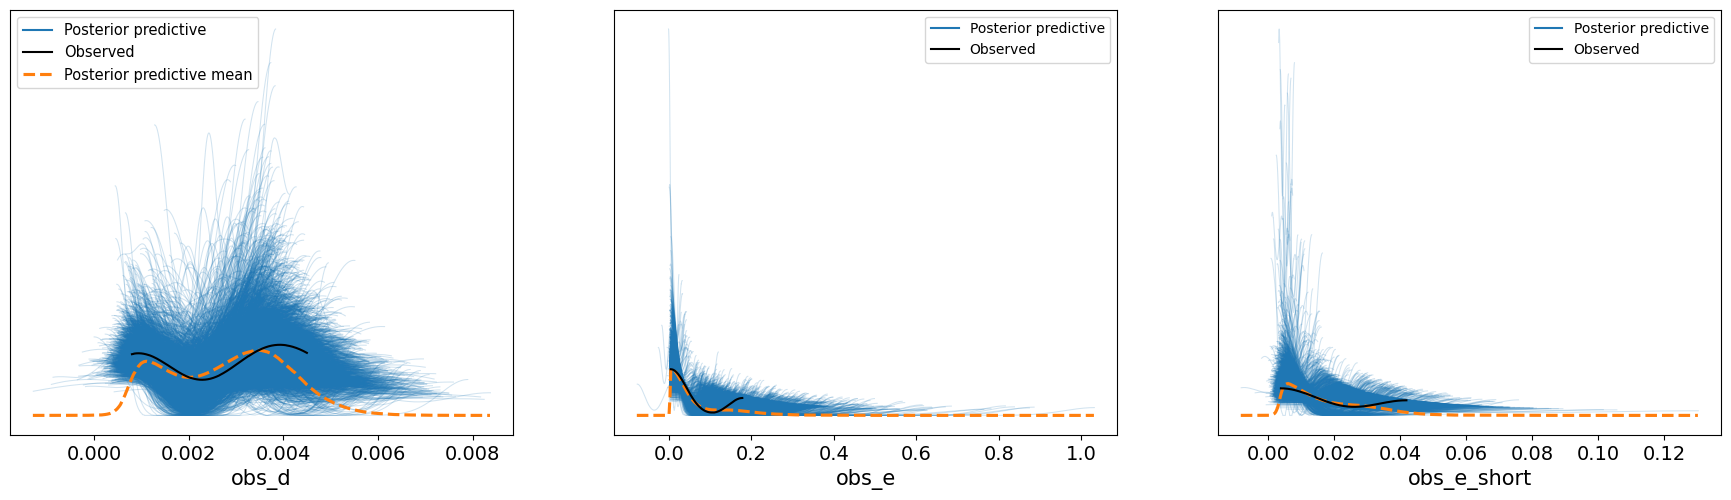

In [28]:
az.plot_ppc(trace)

#### Figures

##### Compare Prior and Posterior Distributions

Text(0.5, 1.02, 'Chr16 Prior vs Posterior Distributions for Sampled Parameters')

<Figure size 600x400 with 0 Axes>

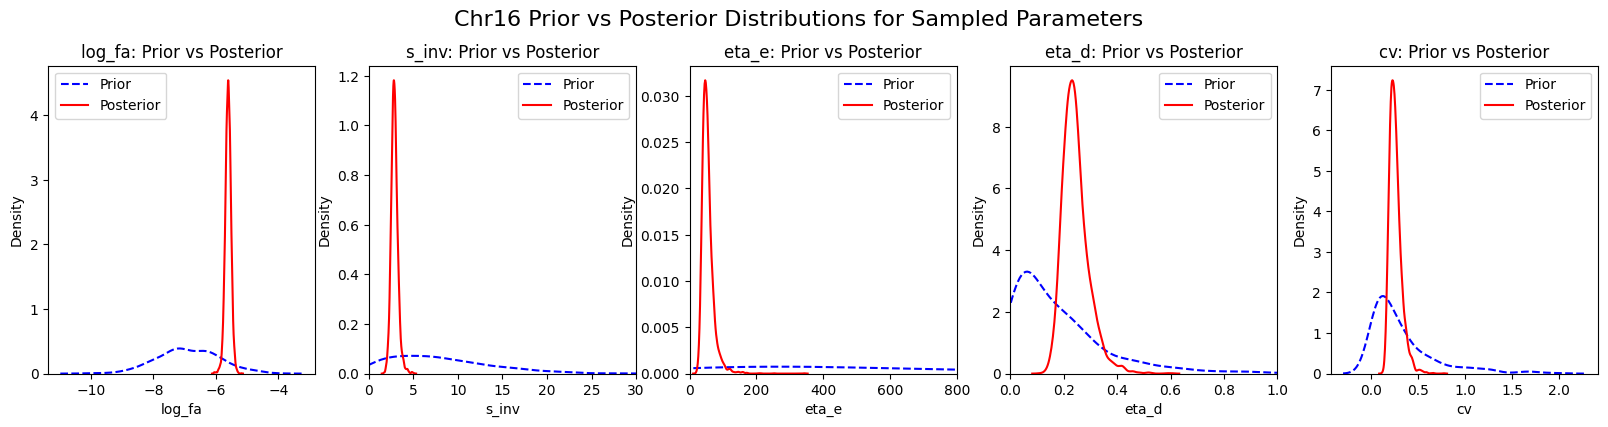

In [29]:
# Plots for directly sampled parameters

plt.figure(figsize=(6, 4))

# params = ['a', 'r', 'fa', 'cv', "log_fa", "s_inv", "eta_e", "eta_d"]
params = ["log_fa", "s_inv", "eta_e", "eta_d", "cv"]

n_params = len(params)
fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

for ax, param in zip(axes, params):
    # Extract prior and posterior samples
    prior_samples = idata.prior[param].values.flatten()
    post_samples = trace.posterior[param].values.flatten()

    # Plot densities
    sns.kdeplot(prior_samples, color="blue", linestyle="--", label="Prior", ax=ax)
    sns.kdeplot(post_samples, color="red", label="Posterior", ax=ax)

    # Labels
    ax.set_xlabel(param)
    ax.set_ylabel("Density")
    ax.set_title(f"{param}: Prior vs Posterior")
    ax.legend()

    if(param == "eta_e"):
      ax.set_xlim((0,800))
    elif(param == "s_inv"):
      ax.set_xlim((0,30))
    elif(param == "eta_d"):
      ax.set_xlim((0,1))

fig.suptitle("Chr16 Prior vs Posterior Distributions for Sampled Parameters", fontsize=16, y=1.02)

Text(0.5, 1.02, 'Chr16 Prior vs Posterior Distributions for Calculated Parameters')

<Figure size 400x400 with 0 Axes>

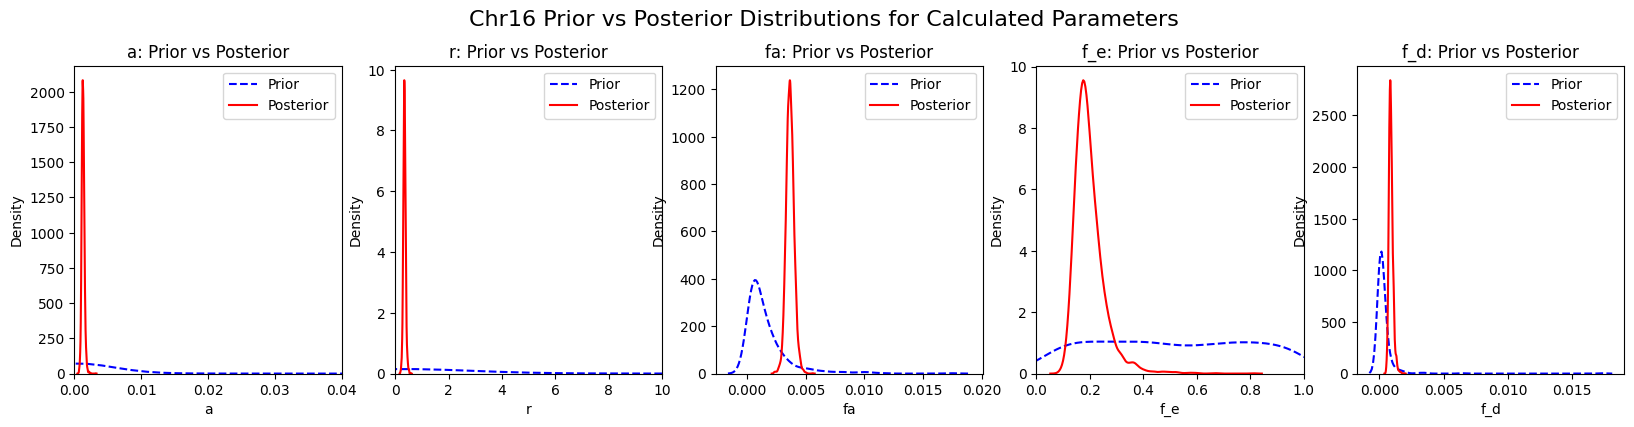

In [30]:
# Plots for transformations of sampled parameters

plt.figure(figsize=(4, 4))

params = ['a', 'r', 'fa', "f_e", "f_d"]

n_params = len(params)
# fig, axes = plt.subplots(2, 3, figsize=(4*3, 4*2), sharey=False)
# fig, axes = plt.subplots(2, 3,  sharey=False)
# axes = axes.flatten()
fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

for ax, param in zip(axes, params):
    # Extract prior and posterior samples
    prior_samples = idata.prior[param].values.flatten()
    post_samples = trace.posterior[param].values.flatten()

    # Plot densities
    sns.kdeplot(prior_samples, color="blue", linestyle="--", label="Prior", ax=ax)
    sns.kdeplot(post_samples, color="red", label="Posterior", ax=ax)

    # Labels
    ax.set_xlabel(param)
    ax.set_ylabel("Density")
    ax.set_title(f"{param}: Prior vs Posterior")
    ax.legend()

    if(param == "f_e"):
      ax.set_xlim((0,1))
    elif(param == "a"):
      ax.set_xlim((0,0.04))
    elif(param == "r"):
      ax.set_xlim((0,10))


fig.suptitle("Chr16 Prior vs Posterior Distributions for Calculated Parameters", fontsize=16, y=1.02)

##### Average trajectory + 95% Confidence Interval

In [33]:
# Sample 1500 parameter sets from the posterior distribtuion and simulate the predicted fraction of activated cells over time
num_samples = 1500
indices = np.random.choice(2000, size=num_samples, replace=False)
times = np.arange(0, 11, 0.5)
n_times = len(times)
posterior_simulations = np.zeros((num_samples*n_times, 4))
z = 0
for i in indices:
    # Sample parameters
    fa  = trace.posterior.fa[0,i].item()
    f_d = trace.posterior.f_d[0,i].item()
    f_e = trace.posterior.f_e[0,i].item()
    s   = trace.posterior.s[0,i].item()

    # Simulate trajectories
    y_d = fa - (fa-f_d)*np.exp(-s*times)
    y_e = fa - (fa-f_e)*np.exp(-s*times)

    # Store results
    posterior_simulations[z:(z+n_times),0] = i
    posterior_simulations[z:(z+n_times),1] = times
    posterior_simulations[z:(z+n_times),2] = y_d*100
    posterior_simulations[z:(z+n_times),3] = y_e*100
    z = z + n_times


In [36]:
# Simulate average:
fa = chr16_summary.loc["fa","mean"]
s = chr16_summary.loc["s","mean"]
f_e = chr16_summary.loc["f_e","mean"]
f_d = chr16_summary.loc["f_d","mean"]

# Simulate trajectories
y_d = fa - (fa-f_d)*np.exp(-s*times)
y_e = fa - (fa-f_e)*np.exp(-s*times)

data = {"time" : times,
        "y_d" : y_d*100,
        "y_e" : y_e}
average_traj = pd.DataFrame(data)

(0.0, 1.0)

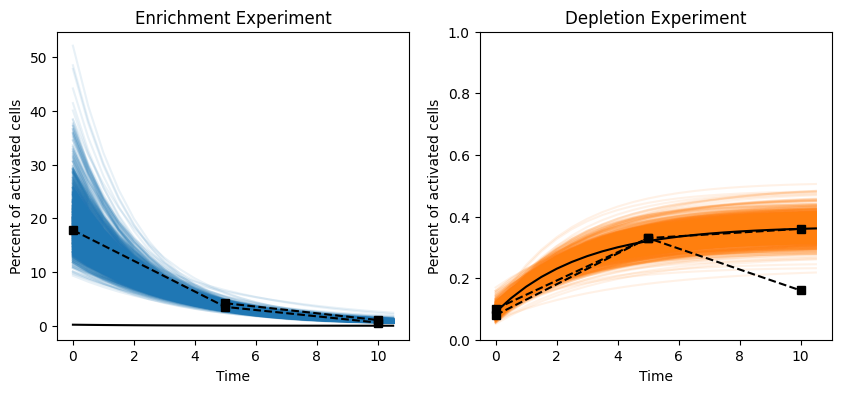

In [37]:
# Plot individual trajectories from posterior samples

# Format data
df = pd.DataFrame(
    posterior_simulations,
    columns=["group", "time", "y_d", "y_e"]
)

# group ids should be integers
df["group"] = df["group"].astype(int)

# Make figure

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# ---- Enrichment Experiment ----
# Posterior samples
sns.lineplot(
    data=df,
    x="time",
    y="y_e",
    units="group",
    alpha = 0.1,
    estimator=None,
    ax = axes[0]
)

# Add mean trajectories:
sns.lineplot(data=average_traj, x="time", y= "y_e", color="black", ax = axes[0])

# Add observed data
axes[0].plot(day[:(len(day)-1)], obs_data_enrich[:(len(day)-1), 0]*100, color='black', marker='s', linestyle='--', label='Observed Data Replicates', zorder=4)
axes[0].plot(day_short[:(len(day_short)-1)], obs_data_enrich_short[:(len(day_short)-1), 0]*100, color='black', marker='s', linestyle='--')

axes[0].set_title("Enrichment Experiment")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Percent of activated cells")

# ---- Depletion Experiment ----

sns.lineplot(
    data=df,
    x="time",
    y="y_d",
    units="group",
    alpha = 0.1,
    estimator=None,
    color="tab:orange",
    ax = axes[1]
)

# Add mean trajectories:
sns.lineplot(data=average_traj, x="time", y= "y_d", color="black", ax = axes[1])

# Add observed data
axes[1].plot(day[:(len(day)-1)], obs_data_deplete[:(len(day)-1), :]*100, color='black', marker='s', linestyle='--')

axes[1].set_title("Depletion Experiment")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Percent of activated cells")
axes[1].set_ylim(0,1)


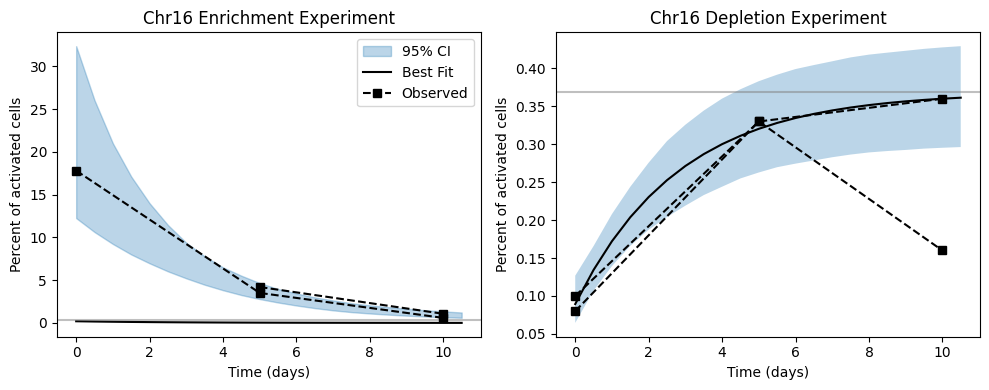

In [38]:
# Plot calculated 95% confidence intervals

# Format data
df = pd.DataFrame(
    posterior_simulations,
    columns=["group", "time", "y_d", "y_e"]
)

# group ids should be integers
df["group"] = df["group"].astype(int)

# Compute posterior summaries
summary = (
    df.groupby("time")
      .agg(
          y_e_mean=("y_e", "mean"),
          y_e_lo=("y_e", lambda x: np.quantile(x, 0.025)),
          y_e_hi=("y_e", lambda x: np.quantile(x, 0.975)),
          y_d_mean=("y_d", "mean"),
          y_d_lo=("y_d", lambda x: np.quantile(x, 0.025)),
          y_d_hi=("y_d", lambda x: np.quantile(x, 0.975)),
      )
      .reset_index()
)


# Make figure
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# ---- Enrichment Experiment ----
axes[0].fill_between(
    summary["time"],
    summary["y_e_lo"],
    summary["y_e_hi"],
    alpha=0.3,
    color="tab:blue",
    label="95% CI"
)

# Add mean trajectories:
sns.lineplot(data=average_traj, x="time", y= "y_e", color="black", ax = axes[0], label="Best Fit")

# Observed data
axes[0].plot(
    day[:(len(day)-1)],
    obs_data_enrich[:(len(day)-1), 0] * 100,
    color="black",
    marker="s",
    linestyle="--",
    label="Observed",
    zorder=4
)

axes[0].plot(
    day_short[:(len(day_short)-1)],
    obs_data_enrich_short[:(len(day_short)-1), 0] * 100,
    color="black",
    marker="s",
    linestyle="--"
)

# Add asymptotic fraction
axes[0].axhline(
    y=fa*100,
    color="gray",
    linestyle="-",
    linewidth=1.5,
    alpha=0.5
)


axes[0].set_title("Chr16 Enrichment Experiment")
axes[0].set_xlabel("Time (days)")
axes[0].set_ylabel("Percent of activated cells")
axes[0].legend()

# ---- Depletion Experiment ----
axes[1].fill_between(
    summary["time"],
    summary["y_d_lo"],
    summary["y_d_hi"],
    alpha=0.3,
    label="95% CI"
)

# Add mean trajectories:
sns.lineplot(data=average_traj, x="time", y= "y_d", color="black", ax = axes[1], label="Best Fit")

# Observed data
axes[1].plot(
    day[:(len(day)-1)],
    obs_data_deplete[:(len(day)-1), :] * 100,
    color="black",
    marker="s",
    linestyle="--",
    label="Observed"
)


# Add asymptotic fraction
axes[1].axhline(
    y=fa*100,
    color="gray",
    linestyle="-",
    linewidth=1.5,
    alpha=0.5
)

axes[1].set_title("Chr16 Depletion Experiment")
axes[1].set_xlabel("Time (days)")
axes[1].set_ylabel("Percent of activated cells")
axes[1].legend_ = None

plt.tight_layout()
plt.show()


#### Calculate fraction acivated at any moment
Sample the posterior for r and a, simulate for 7 weeks, and count the number of cells active at any moment. Then calculated the mean and 95% HDI.

In [41]:
# Simulate as ODE to count cumulative activated cells
def model_cumulative(y,t,a,r):
    dy=[0,0,0]
    dy[0] = - a*y[0] + r*y[1] # latent cells
    dy[1] = a*y[0] - r*y[1] # reactivated cells
    dy[2] = a*y[0] # Cumulative activated cells
    return dy

tvec=np.arange(0,10,0.001)
cumulative_percent = np.zeros((len(indices), 1))

# Sample parameters and run simulation
z=0
for i in indices:
    # Sample parameters
    fa = trace.posterior.fa[0,i].item()
    r  = trace.posterior.r[0,i].item()
    a  = trace.posterior.a[0,i].item()

    # Simulate trajectories
    ic = [(1-fa), fa, fa]
    soln=odeint(model_cumulative,ic,tvec,args=(a,r))
    p = soln[len(tvec)-1, 2]*100

    # Store results
    cumulative_percent[z] = p
    z=z+1

# Calculate mean and 95% HDI
hdi = az.hdi(cumulative_percent, hdi_prob=0.95)
mean = np.mean(cumulative_percent)

print("Percent of cells active at any point during 10 days is {:1.3f}%".format(mean))
print("Lower bound on Percent of cells active at any point during 10 days is {:1.3f}%".format(hdi[0][0]))
print("Upper bound on Percent of cells active at any point during 10 days is {:1.3f}%".format(hdi[0][1]))


Percent of cells active at any point during 10 days is 1.658%
Lower bound on Percent of cells active at any point during 10 days is 1.247%
Upper bound on Percent of cells active at any point during 10 days is 2.121%


/tmp/ipython-input-1888329566.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(cumulative_percent, hdi_prob=0.95)


## ZNF721

### Fit to enrichment & depletion experiments simultaneously

When fitting the ZNF721 data, we assume that the fraction of activated cells is at steady state prior to day 5. This fraction is approximately the fraction of activated cells at day 5 in the "not depleted" experimental condition. This should inform the on rate in response to T-cell stimulation. At day 5, the on rate drops so both the "not depleted" and "depleted'' experiments trend towards a lower fraction of activated cells. The rate at which this happens informs the off rate.

Function we are fitting to data:

From day 5 to 7 in "no depletion" experiment:

$Y(t) =  f_{a_w} - (f_{a_w}  - f_{a_s}) e^{-(r+a_w)t}$

From day 5 to 7 in "depletion experiment":

$Y(t) =  f_{a_w} - (f_{a_w}  - f_{d}) e^{-(r+a_w)t}$

Where $f_{a_s}$ and$f_{a_w}$ are the fraction of active cells at equilibrium prior to and after stimulation waning, respectively:

$ f_ {a_s} = a/(a+r)$, $ f_ {a_w} = a_w/(a_w+r)$,

And $f_d$ is the fraction of activated cells following the depletion intervention.

We assume:
- sampling error is negligble due to large cell counts
- variation between replicates can be described with a normal distribution with standard deviation proportional to mean ($\sigma = cv*\mu$ where $cv$ is the coefficient of variation)
- $a$ and $r$ are the same between experiments, but $a$ drops after day 5. Therefore, we have $a$ during stimulation (prior to the observed data), and $a_w$, which is the on rate after stimulation wanes, starting day 5
- The rate at which activated cells stop expressing HIV ($r$) is constant throughout the experiment
- The initial fraction of activated cells differs between experiments, and we treat it as an unknown since our measurement error model applies to it. - We assume that the initial fraction for the "not depleted" scenario is the steady state fraction activated before stimulation wanes


We are sampling:
- $s^{-1}$, where $s = a_w+r$, from a Half-normal distribution with sigma = 10
- $log(f_w)$, the fraction at equilibrium at the end of data collection ($f_w = a_w/s$) from a normal distribution with mean $log(10^-3)$ and standard deviation 1
- $v1$, a factor used to calculate $\eta_no_d$ so that it remains bounded bewteen 1 and 1/fw, sampled from $Beta(1,1)$
- $v2$, a factor used to calculate $\eta_d$ so that it remains bounded bewteen 1 and 1/fw, sampled from $Beta(1,1)$
- $cv$, the coefficient of variation of measurement error from $Gamma(1,3)$

We can calcualte:
- $\eta_{no_d}$, the percent activated relative to steady state fraction of activated cells at the start of the "no depletion" data collection as $1+v1*(1/f_w-1)$
- $\eta_d$, the percent activated relative to steady state fraction of activated cells at the start of the "depletion" data collection as $1+v2*(1/f_w-1)$
- $f_d$, the initial fraction from the depletion experiment as $\eta_d*f_w$
- $fas$, the initial fraction from the "no depletion" experiment as $\eta_{no_d}*f_w$
- $a_w = faw*s$, the on rate starting day 5 (once stimulation has waned)
- $a = fas*r/(1-fas)$, the on rate prior to day 5 (assuming the percent of activated cells is at steady state)
- $r = s-a_w$, the rate at which active cells stop expressing HIV




In [42]:
# Experiimental data
day = np.array([121, 122, 126, 132, 144, 168])/24

# Depletion experiment (3 replicates)
obs_data = np.zeros((len(day), 3))
obs_data[:,0] = [0.13, 0.17, 0.17, 0.13, 0.089, 0.020]
obs_data[:,1] = [0.16, 0.20, 0.16, 0.15, 0.073, 0.035]
obs_data[:,2] = [0.18, 0.13, 0.20, 0.18, 0.075, 0.028]
obs_data_deplete = obs_data/100

# No depletion scenario (3 replicates)
obs_data = np.zeros((len(day), 3))
obs_data[:,0] = [1.66, 1.33, 1.23, 0.93, 0.52, 0.13]
obs_data[:,1] = [1.67, 1.35, 1.23, 0.71, 0.41, 0.13]
obs_data[:,2] = [1.58, 1.23, 1.17, 0.73, 0.52, 0.12]
obs_data_no_d= obs_data/100


In [43]:
# Fit the model
with pymc.Model() as latency_model_z:

  # Priors
  log_faw = pymc.Normal("log_faw", mu = np.log(1e-3), sigma = 1)
  s_inv =   pymc.HalfNormal("s_inv", sigma = 10)
  cv =      pymc.Gamma("cv", alpha = 1, beta = 1)
  v1 =      pymc.Beta("v1",  alpha = 1, beta = 1)
  v2 =      pymc.Beta("v2",  alpha = 1, beta = 1)

  # Calculated parameters for reporting out
  faw      = pymc.Deterministic("faw", np.exp(log_faw))
  eta_no_d = pymc.Deterministic("eta_no_d", 1+v1*(1/faw-1))
  eta_d    = pymc.Deterministic("eta_d", 1+v2*(1/faw-1))
  fas      = pymc.Deterministic("fas", eta_no_d*faw)
  f_d      = pymc.Deterministic("f_d", eta_d*faw)
  s        = pymc.Deterministic("s",   1/s_inv)
  a_w      = pymc.Deterministic("a_w", faw*s)
  r        = pymc.Deterministic("r",   s-a_w)
  a        = pymc.Deterministic("a",   fas*r/(1-fas))


  # Calculate expected fraction activated at this time
  exp_frac_deplete    = pymc.Deterministic("exp_frac_deplete",    faw - (faw-f_d)*pymc.math.exp(-s*(day-5)))
  exp_frac_no_deplete = pymc.Deterministic("exp_frac_no_deplete", faw - (faw-fas)*pymc.math.exp(-s*(day-5)))

  # Expand to match 4 × 100 observed matrix
  mu_d    = exp_frac_deplete[:, None]
  sigma_d = (cv * exp_frac_deplete)[:, None]

  mu_e    = exp_frac_no_deplete[:, None]
  sigma_e = (cv * exp_frac_no_deplete)[:, None]

  # Likelihood
  obs_d = pymc.Normal("obs_d",    mu = mu_d, sigma = sigma_d, observed = obs_data_deplete)
  obs_e = pymc.Normal("obs_no_d", mu = mu_e, sigma = sigma_e, observed = obs_data_no_d)

  # Sample posterior
  trace_z = pymc.sample(2000, target_accept=0.9)

Output()

#### Prior predictive check

/tmp/ipython-input-3844638872.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


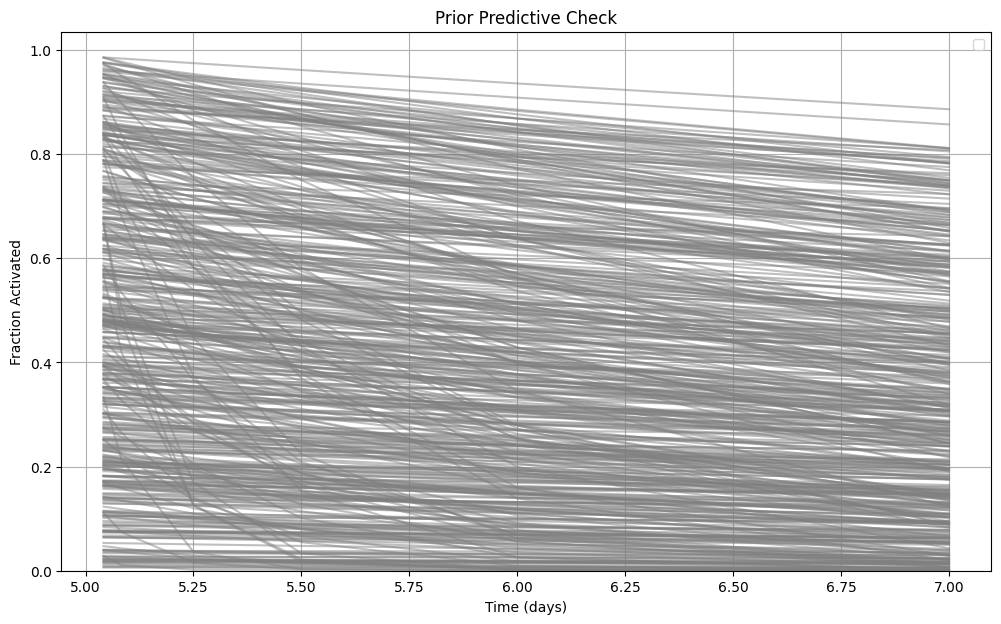

In [44]:
with latency_model_z:
  idata_z = pymc.sample_prior_predictive(draws=500)

plt.figure(figsize=(12, 7))

prior = idata_z.prior["exp_frac_deplete"]

# Plot individual processed replicates as lines
num_replicates = prior.shape[1]
for j in range(num_replicates):
    plt.plot(day, prior[0, j, :], color='grey', alpha=0.5)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title("Prior Predictive Check")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()

#### Posterior distributions

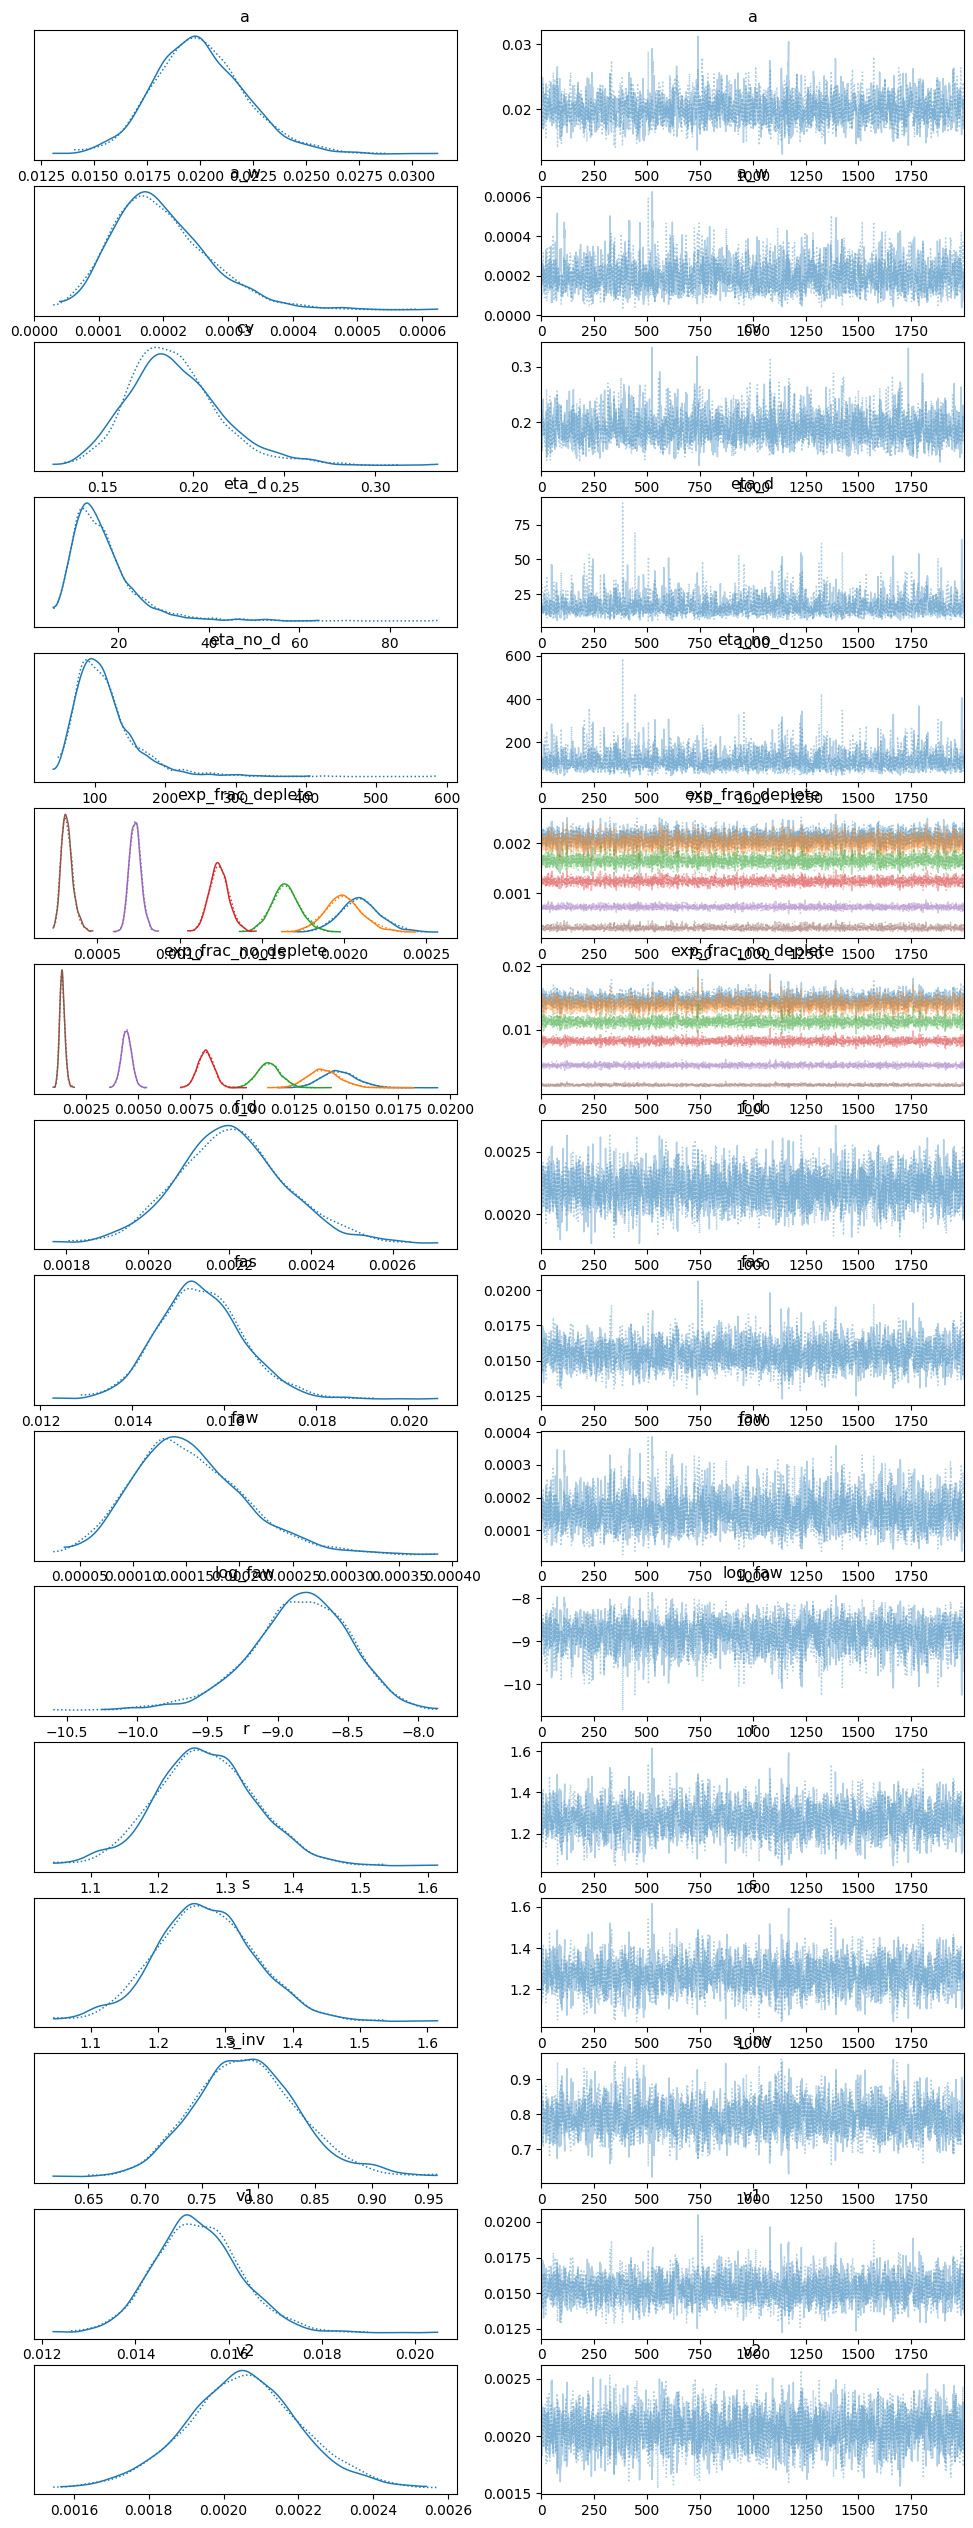

In [45]:
az.plot_trace(trace_z);

In [46]:
ZNF_summary = az.summary(trace_z, round_to = "none", var_names = ["a", "r", "faw", "cv", "fas", "f_d", "a_w", "s"], hdi_prob = 0.95)
ZNF_summary

mean        sd  hdi_2.5%  hdi_97.5%  mcse_mean       mcse_sd  \
a    0.020019  0.002176  0.015741   0.024349   0.000055  4.353180e-05   
r    1.270221  0.074599  1.116090   1.409724   0.001844  1.294027e-03   
faw  0.000153  0.000052  0.000059   0.000261   0.000001  9.099792e-07   
cv   0.189685  0.025362  0.142160   0.240958   0.000521  4.735930e-04   
fas  0.015480  0.000930  0.013666   0.017340   0.000021  1.665310e-05   
f_d  0.002204  0.000132  0.001960   0.002488   0.000002  2.045358e-06   
a_w  0.000196  0.000074  0.000066   0.000344   0.000002  1.431960e-06   
s    1.270417  0.074648  1.116164   1.410051   0.001845  1.294905e-03   

        ess_bulk     ess_tail     r_hat  
a    1594.247029  2037.715434  1.001159  
r    1635.718024  1911.047962  1.000353  
faw  2197.293326  1866.346510  1.000574  
cv   2398.819838  2585.738621  1.001095  
fas  2063.107407  2056.899491  1.001466  
f_d  3086.126524  2885.009354  0.999871  
a_w  2030.334412  1924.451655  1.000699  
s    1635.592775  1911.047962  1.000356

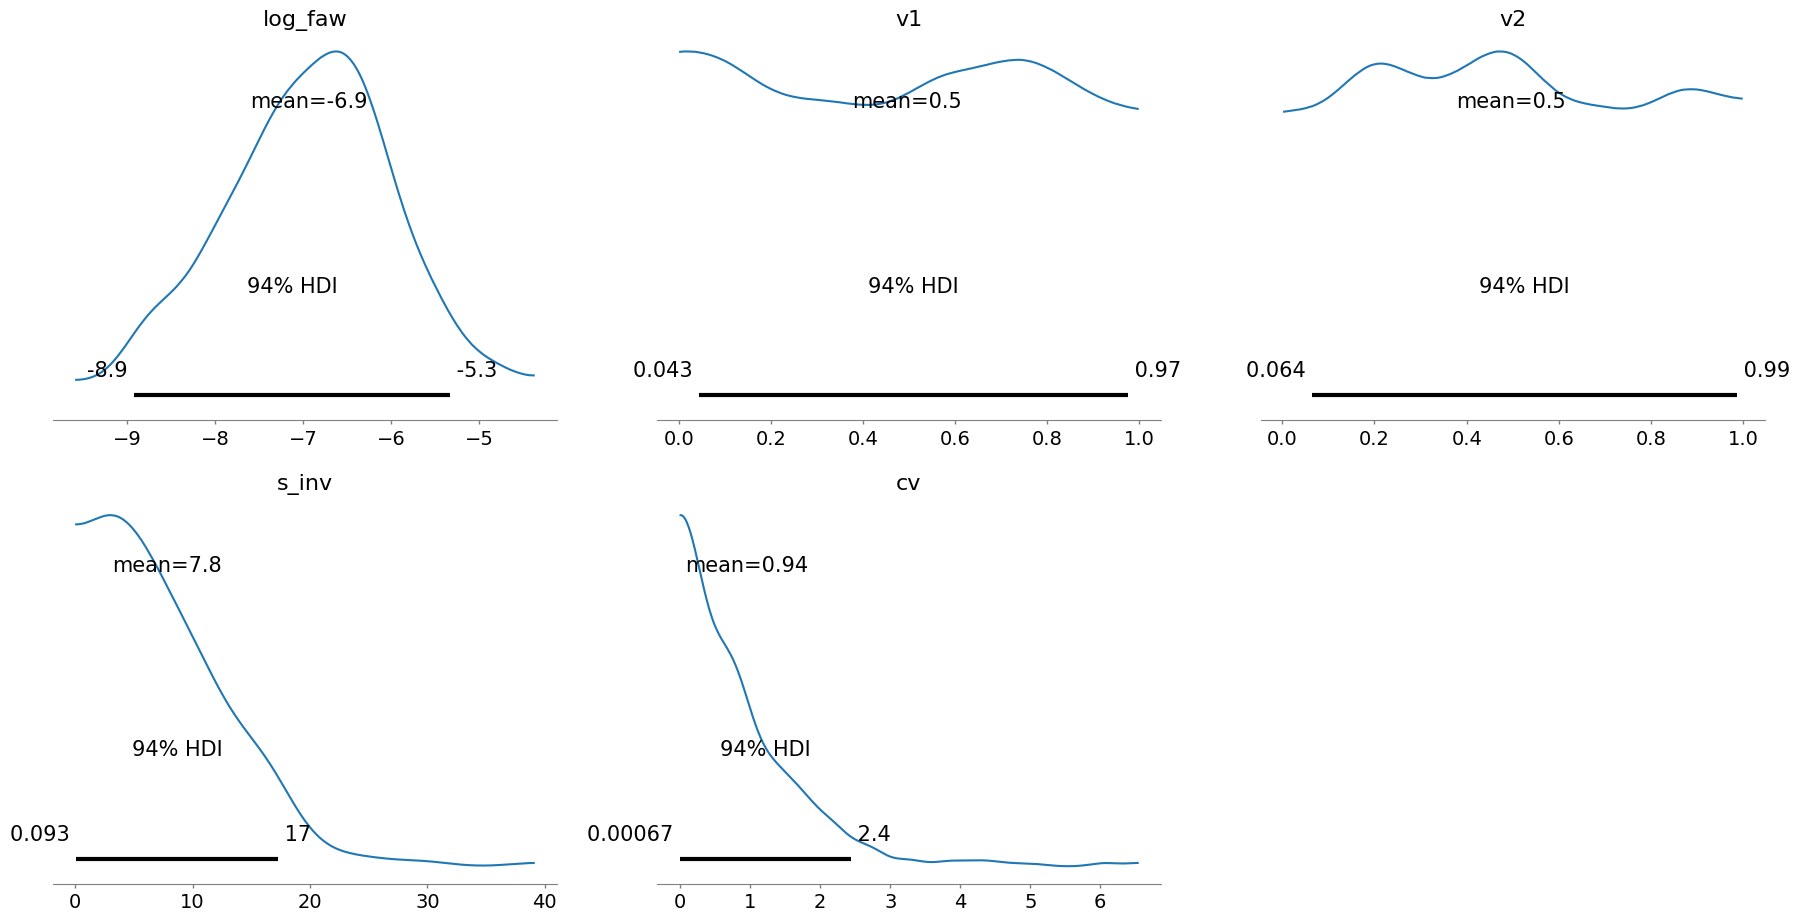

In [47]:
az.plot_posterior(idata_z, var_names=['log_faw', 'v1', 'v2', 's_inv', 'cv'], group = "prior");

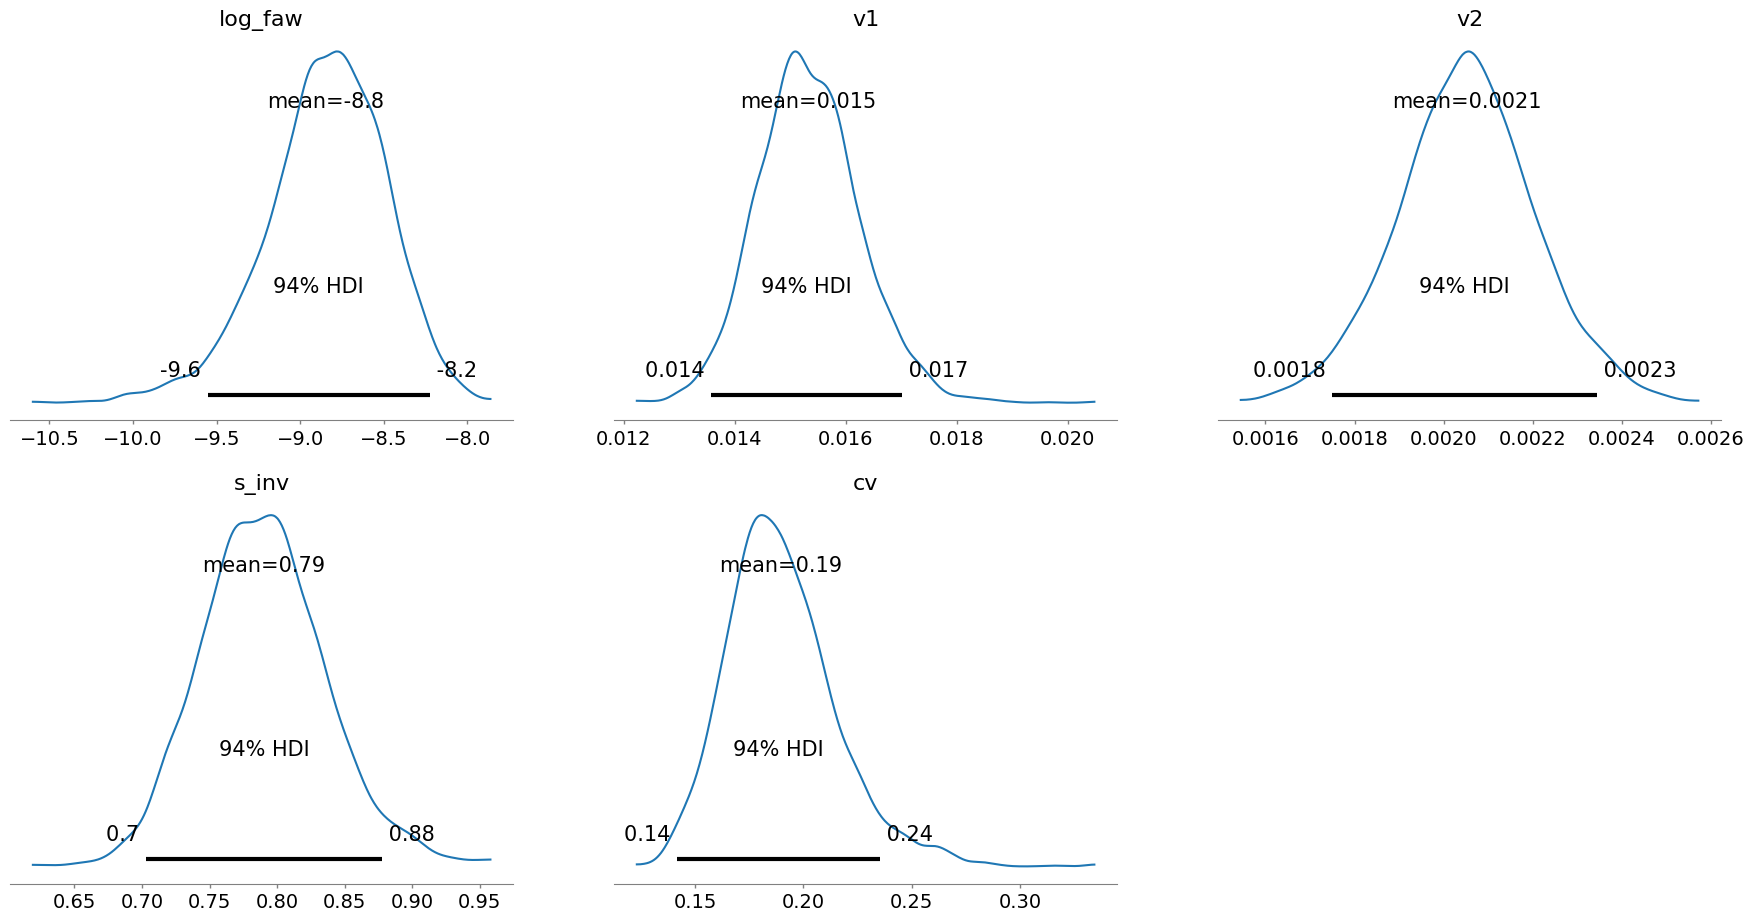

In [48]:
az.plot_posterior(trace_z, var_names=['log_faw', 'v1', 'v2', 's_inv', 'cv'], group = "posterior");

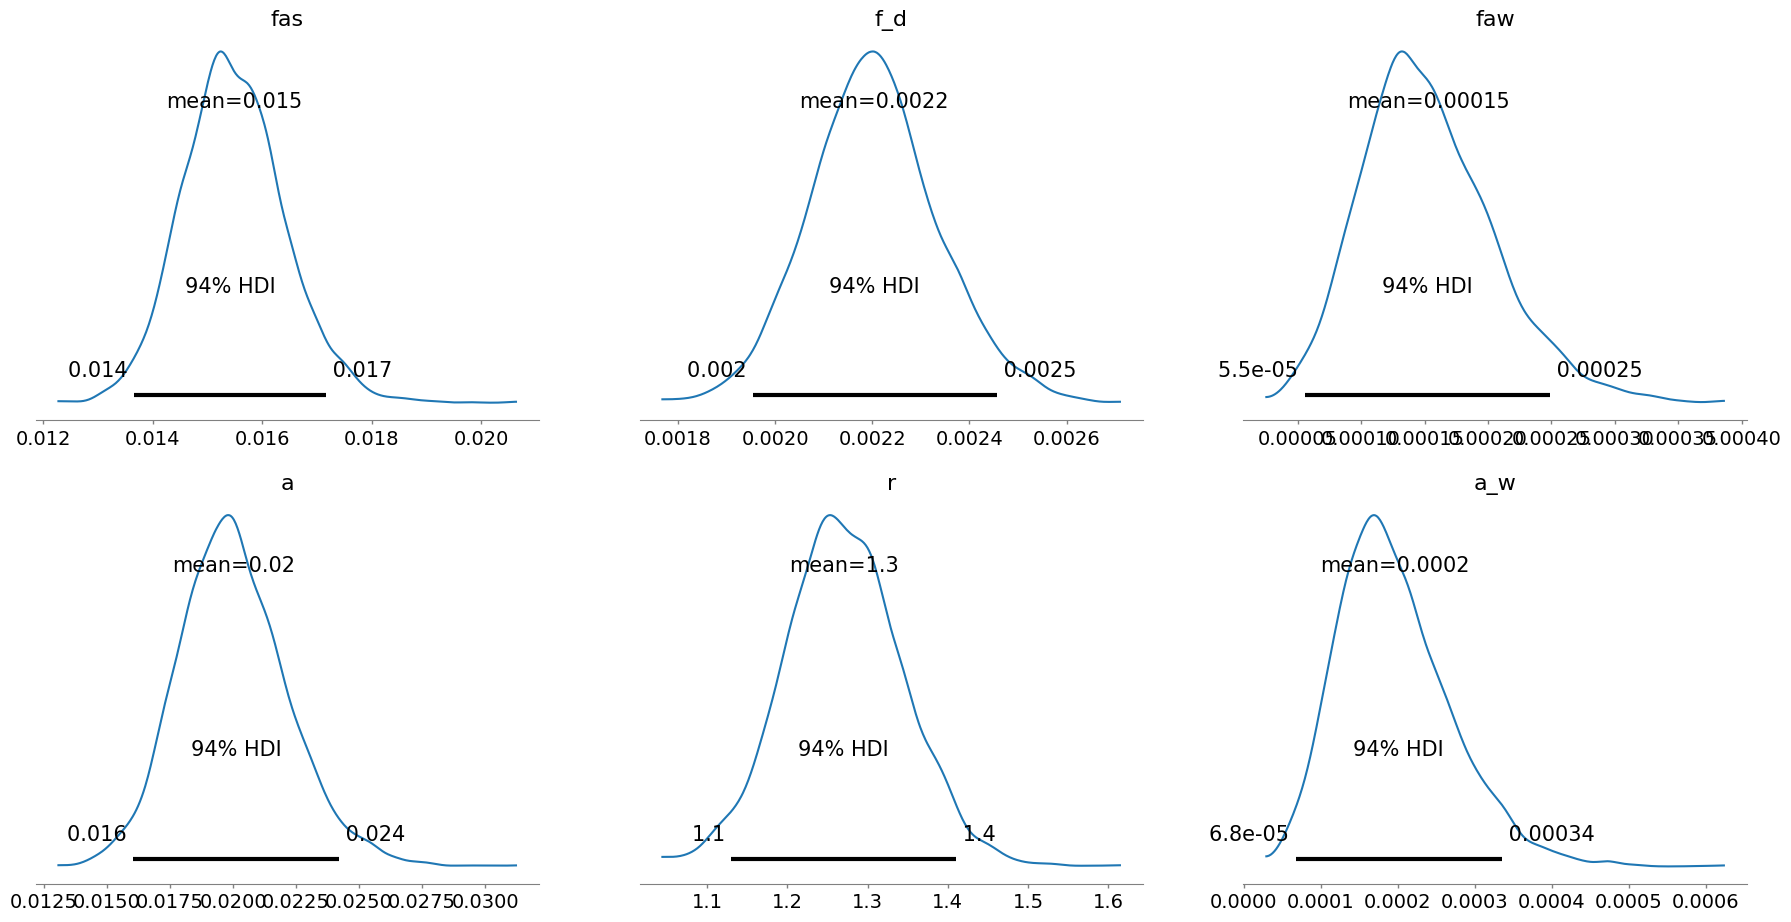

In [49]:
az.plot_posterior(trace_z, var_names=['fas', 'f_d', 'faw', 'a', 'r', 'a_w'], group = "posterior");

#### Posterior predictive check

In [50]:
# Posterior predictive check:
with latency_model_z:
    trace_z.extend(pymc.sample_posterior_predictive(trace_z))

Output()

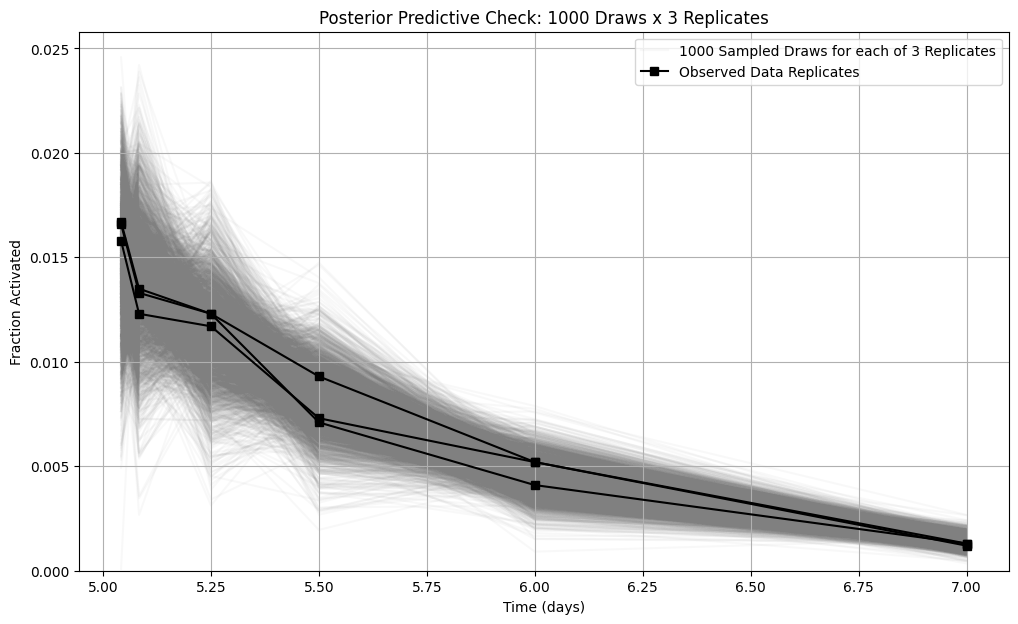

In [51]:
# Get posterior predictive samples
ppc = trace_z.posterior_predictive["obs_no_d"]

# 1. Filter to just one chain (e.g., the first chain at index 0)
one_chain_ppc = ppc.values[0, :, :, :] # Shape (num_draws, num_time_points, num_replicates)

num_draws_total = one_chain_ppc.shape[0]
num_time_points = one_chain_ppc.shape[1]
num_replicates = one_chain_ppc.shape[2]

# 2. Take 100 random samples from the posterior draws
num_samples_to_plot = 1000
np.random.seed(42) # For reproducibility of random draws
random_draw_indices = np.random.choice(num_draws_total, size=num_samples_to_plot, replace=False)
selected_draws = one_chain_ppc[random_draw_indices, :, :] # Shape (50, 4, 100)

plt.figure(figsize=(12, 7))

# Plot individual posterior predictive samples as lines
first_plot_line = True
for i in range(num_samples_to_plot): # Iterate over the 50 selected draws
    for j in range(num_replicates):  # Iterate over the 100 replicates
        if first_plot_line:
            plt.plot(day, selected_draws[i, :, j], color='grey', alpha=0.05, label=f'{num_samples_to_plot} Sampled Draws for each of {num_replicates} Replicates', zorder=1)
            first_plot_line = False
        else:
            plt.plot(day, selected_draws[i, :, j], color='grey', alpha=0.05, zorder=1)

# # Overlay the 'true' simulated data (y) for comparison
# plt.plot(day, y, color='black', marker='*', linestyle='--', label='True Simulated Data', zorder=3)

# Plot the observed data
num_observed_replicates = obs_data_no_d.shape[1]
for k in range(num_observed_replicates):
    if k == 0:
        plt.plot(day, obs_data_no_d[:, k], color='black', marker='s', linestyle='-', label='Observed Data Replicates', zorder=4)
    else:
        plt.plot(day, obs_data_no_d[:, k], color='black', marker='s', linestyle='-', zorder=4)

mean_processed_ppc = one_chain_ppc.mean(axis=1)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title(f"Posterior Predictive Check: {num_samples_to_plot} Draws x {num_replicates} Replicates")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()

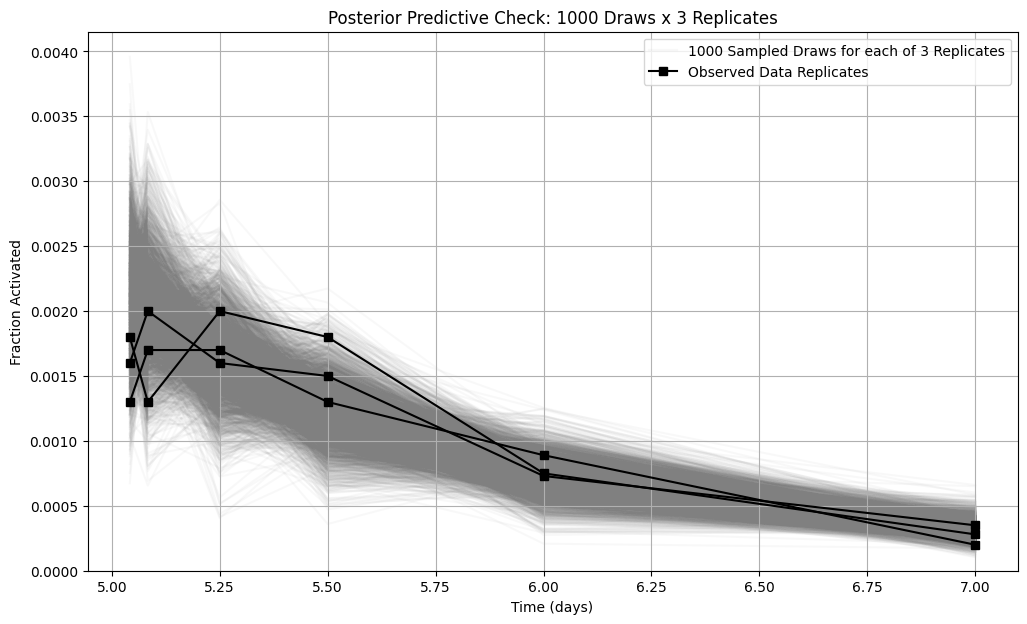

In [52]:
# Get posterior predictive samples
ppc = trace_z.posterior_predictive["obs_d"]

# 1. Filter to just one chain (e.g., the first chain at index 0)
one_chain_ppc = ppc.values[0, :, :, :] # Shape (num_draws, num_time_points, num_replicates)

num_draws_total = one_chain_ppc.shape[0]
num_time_points = one_chain_ppc.shape[1]
num_replicates = one_chain_ppc.shape[2]

# 2. Take 100 random samples from the posterior draws
num_samples_to_plot = 1000
np.random.seed(42) # For reproducibility of random draws
random_draw_indices = np.random.choice(num_draws_total, size=num_samples_to_plot, replace=False)
selected_draws = one_chain_ppc[random_draw_indices, :, :] # Shape (50, 4, 100)

plt.figure(figsize=(12, 7))

# Plot individual posterior predictive samples as lines
first_plot_line = True
for i in range(num_samples_to_plot): # Iterate over the 50 selected draws
    for j in range(num_replicates):  # Iterate over the 100 replicates
        if first_plot_line:
            plt.plot(day, selected_draws[i, :, j], color='grey', alpha=0.05, label=f'{num_samples_to_plot} Sampled Draws for each of {num_replicates} Replicates', zorder=1)
            first_plot_line = False
        else:
            plt.plot(day, selected_draws[i, :, j], color='grey', alpha=0.05, zorder=1)

# # Overlay the 'true' simulated data (y) for comparison
# plt.plot(day, y, color='black', marker='*', linestyle='--', label='True Simulated Data', zorder=3)

# Plot the observed data
num_observed_replicates = obs_data.shape[1]
for k in range(num_observed_replicates):
    if k == 0:
        plt.plot(day, obs_data_deplete[:, k], color='black', marker='s', linestyle='-', label='Observed Data Replicates', zorder=4)
    else:
        plt.plot(day, obs_data_deplete[:, k], color='black', marker='s', linestyle='-', zorder=4)

mean_processed_ppc = one_chain_ppc.mean(axis=1)

plt.xlabel("Time (days)")
plt.ylabel("Fraction Activated")
plt.title(f"Posterior Predictive Check: {num_samples_to_plot} Draws x {num_replicates} Replicates")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure y-axis starts at 0 as it's a fraction
plt.show()

array([<Axes: xlabel='obs_d'>, <Axes: xlabel='obs_no_d'>], dtype=object)

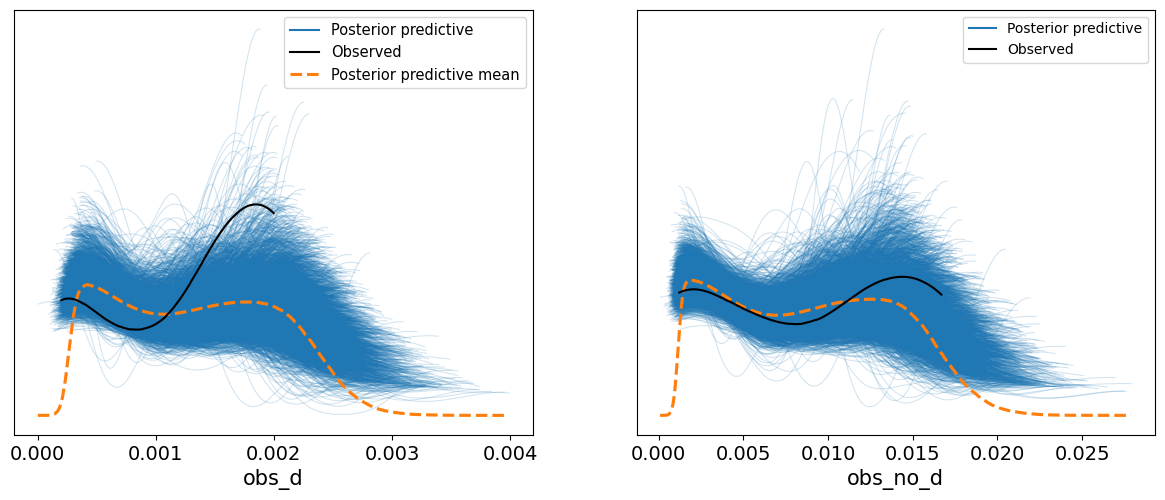

In [53]:
az.plot_ppc(trace_z)

#### Figures

##### Compare Prior and Posterior Distributions

Text(0.5, 1.02, 'ZNF721 Prior vs Posterior Distributions for Sampled Parameters')

<Figure size 600x400 with 0 Axes>

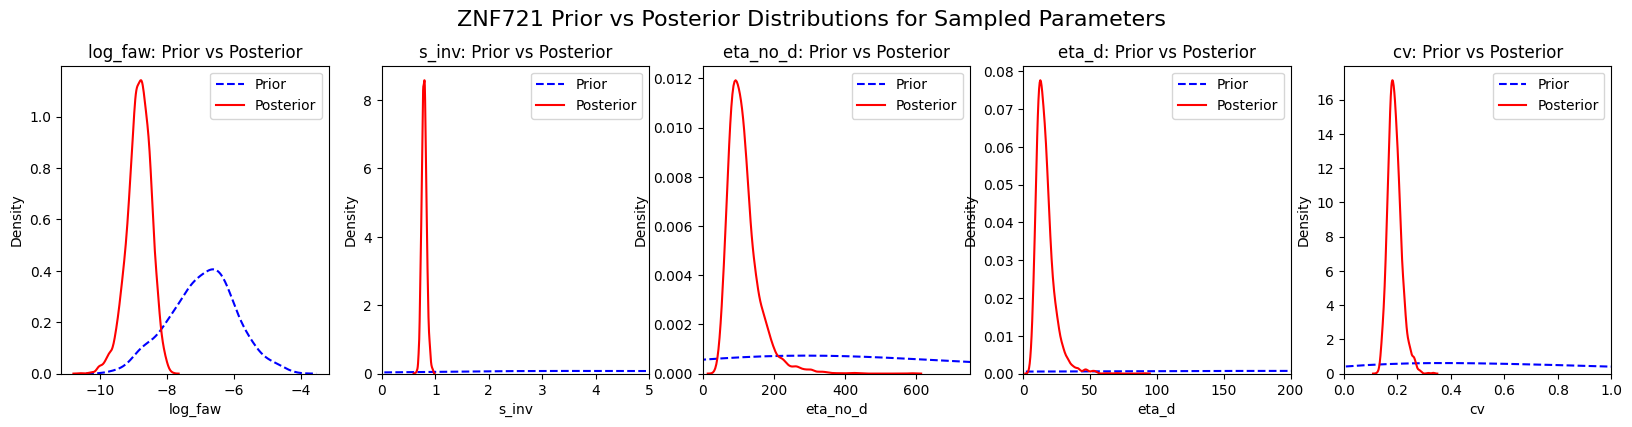

In [54]:
# Plot directly sampled parameters
plt.figure(figsize=(6, 4))

# params = ["log_faw", "s_inv", "eta_no_d", "eta_d", "cv", "v1", "v2"]
params = ["log_faw", "s_inv", "eta_no_d", "eta_d", "cv"]

# n_params = len(params)
# nrow = 2
# ncol = round(n_params/nrow)
# fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow), sharey=False)
# axes = axes.flatten()

n_params = len(params)
fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

for ax, param in zip(axes, params):
    # Extract prior and posterior samples
    prior_samples = idata_z.prior[param].values.flatten()
    post_samples = trace_z.posterior[param].values.flatten()

    # Plot densities
    sns.kdeplot(prior_samples, color="blue", linestyle="--", label="Prior", ax=ax)
    sns.kdeplot(post_samples, color="red", label="Posterior", ax=ax)

    # Labels
    ax.set_xlabel(param)
    ax.set_ylabel("Density")
    ax.set_title(f"{param}: Prior vs Posterior")
    ax.legend()

    if(param == "eta_no_d"):
      ax.set_xlim((0,750))
    elif(param == "s_inv"):
      ax.set_xlim((0,5))
    elif(param == "eta_d"):
      ax.set_xlim((0,200))
    elif(param == "cv"):
      ax.set_xlim((0,1))
    elif(param == "v1"):
      ax.set_xlim((0,0.2))
    elif(param == "v2"):
      ax.set_xlim((0,0.2))


fig.suptitle("ZNF721 Prior vs Posterior Distributions for Sampled Parameters", fontsize=16, y=1.02)

Text(0.5, 1.02, 'ZNF721 Prior vs Posterior Distributions for Calculated Parameters')

<Figure size 400x600 with 0 Axes>

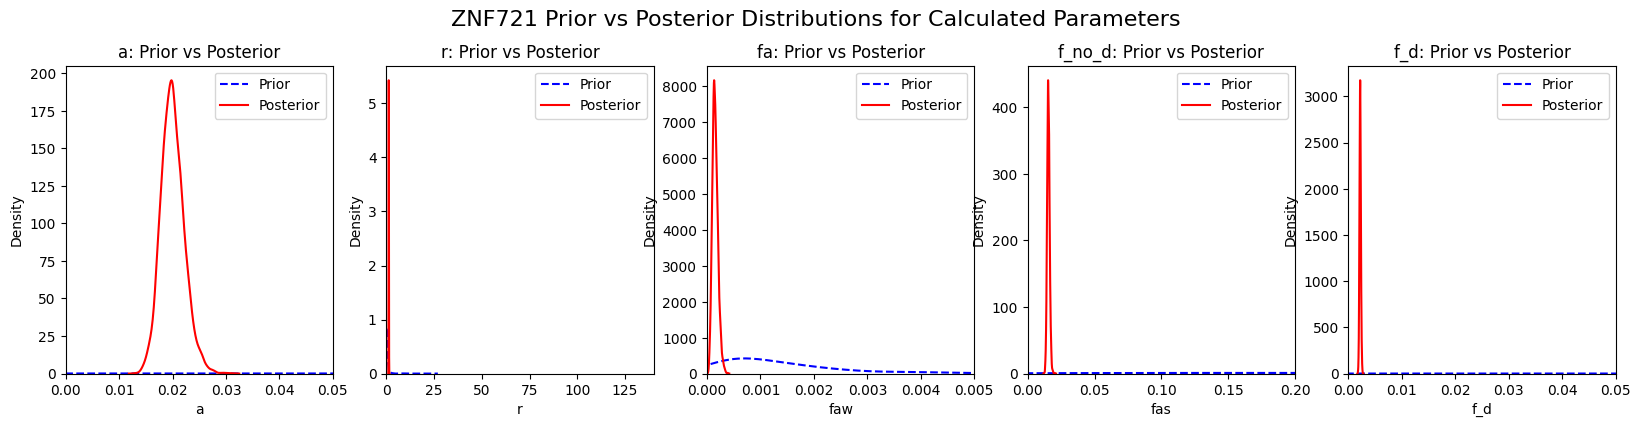

In [55]:
# Plot transformed parameters
plt.figure(figsize=(4, 6))

params = ['a', 'r', 'faw',  "fas", "f_d"]

# n_params = len(params)
# fig, axes = plt.subplots(2, 3, figsize=(4*3, 4*2), sharey=False)
# # fig, axes = plt.subplots(2, 3,  sharey=False)
# axes = axes.flatten()

n_params = len(params)
fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

for ax, param in zip(axes, params):
    # Extract prior and posterior samples
    prior_samples = idata_z.prior[param].values.flatten()
    post_samples = trace_z.posterior[param].values.flatten()

    # Plot densities
    sns.kdeplot(prior_samples, color="blue", linestyle="--", label="Prior", ax=ax)
    sns.kdeplot(post_samples, color="red", label="Posterior", ax=ax)

    # Labels
    ax.set_xlabel(param)
    ax.set_ylabel("Density")
    ax.set_title(f"{param}: Prior vs Posterior")
    ax.legend()

    if(param == "faw"):
      ax.set_xlim((0,0.005))
      ax.set_title("fa: Prior vs Posterior")
    elif(param == "f_d"):
      ax.set_xlim((0,0.05))
    elif(param == "fas"):
      ax.set_xlim((0,0.2))
      ax.set_title("f_no_d: Prior vs Posterior")
    elif(param == "r"):
      ax.set_xlim((0,140))
    elif(param == "a"):
      ax.set_xlim((0,0.05))


fig.suptitle("ZNF721 Prior vs Posterior Distributions for Calculated Parameters", fontsize=16, y=1.02)

##### Average trajectory + 95% Confidence Interval

In [57]:
# Sample parameters from the posterior and simulate the fraction of activated cells over time
num_samples = 1500
indices = np.random.choice(trace_z.posterior.r[0,:].shape[0], size=num_samples, replace=False)
times = np.arange(5, 8, 0.1)
n_times = len(times)
posterior_simulations_z = np.zeros((num_samples*n_times, 4))
z = 0
for i in indices:
    # Sample parameters
    faw = trace_z.posterior.faw[0,i].item()
    f_d = trace_z.posterior.f_d[0,i].item()
    fas = trace_z.posterior.fas[0,i].item()
    s   = trace_z.posterior.s[0,i].item()

    # Simulate trajectories
    y_d    = faw - (faw-f_d)*np.exp(-s*(times-5))
    y_no_d = faw - (faw-fas)*np.exp(-s*(times-5))

    # Store results
    posterior_simulations_z[z:(z+n_times),0] = i
    posterior_simulations_z[z:(z+n_times),1] = times
    posterior_simulations_z[z:(z+n_times),2] = y_d*100
    posterior_simulations_z[z:(z+n_times),3] = y_no_d*100
    z = z + n_times


In [58]:
# Simulate average:
fas = ZNF_summary.loc["fas","mean"]
faw = ZNF_summary.loc["faw","mean"]
s   = ZNF_summary.loc["s","mean"]
fas = ZNF_summary.loc["fas","mean"]
f_d = ZNF_summary.loc["f_d","mean"]

# Simulate trajectories
y_d    = faw - (faw-f_d)*np.exp(-s*(times-5))
y_no_d = faw - (faw-fas)*np.exp(-s*(times-5))

data = {"time" : times,
        "y_d" : y_d*100,
        "y_no_d" : y_no_d*100}
average_traj_z = pd.DataFrame(data)

Text(0, 0.5, 'Percent of activated cells')

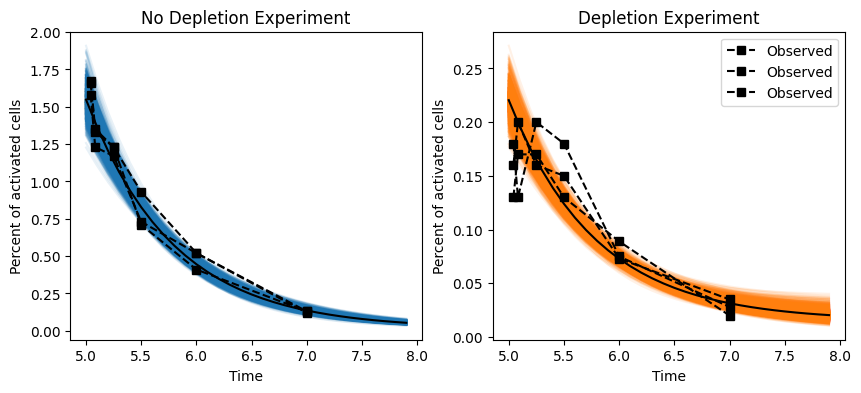

In [62]:
# Plot individual trajectories

# Format data
df_z = pd.DataFrame(
    posterior_simulations_z,
    columns=["group", "time", "y_d", "y_no_d"]
)

# group ids should be integers
df_z["group"] = df_z["group"].astype(int)

# Make figure

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# ---- No Depletion Experiment ----
# Posterior samples
sns.lineplot(
    data=df_z,
    x="time",
    y="y_no_d",
    units="group",
    alpha = 0.1,
    estimator=None,
    ax = axes[0]
)

# Add mean trajectories:
sns.lineplot(data=average_traj_z, x="time", y= "y_no_d", color="black", ax = axes[0])

# Add observed data
for i in range(obs_data_no_d.shape[1]):
    axes[0].plot(
        day,
        obs_data_no_d[:,i]*100,
        color="black",
        marker="s",
        linestyle="--",
        label="Observed" if i == 0 else None
    )

# # Add observed data
# axes[0].plot(day[:(len(day)-1)], obs_data_enrich[:(len(day)-1), 0]*100, color='black', marker='s', linestyle='--', label='Observed Data Replicates', zorder=4)
# axes[0].plot(day_short[:(len(day_short)-1)], obs_data_enrich_short[:(len(day_short)-1), 0]*100, color='black', marker='s', linestyle='--')

axes[0].set_title("No Depletion Experiment")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Percent of activated cells")

# ---- Depletion Experiment ----

sns.lineplot(
    data=df_z,
    x="time",
    y="y_d",
    units="group",
    alpha = 0.1,
    estimator=None,
    color="tab:orange",
    ax = axes[1]
)

# Observed data
axes[1].plot(
    day,
    obs_data_deplete*100,
    color="black",
    marker="s",
    linestyle="--",
    label="Observed"
)

# Add mean trajectories:
sns.lineplot(data=average_traj_z, x="time", y= "y_d", color="black", ax = axes[1])

# # Add observed data
# axes[1].plot(day[:(len(day)-1)], obs_data_deplete[:(len(day)-1), :]*100, color='black', marker='s', linestyle='--')

axes[1].set_title("Depletion Experiment")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Percent of activated cells")


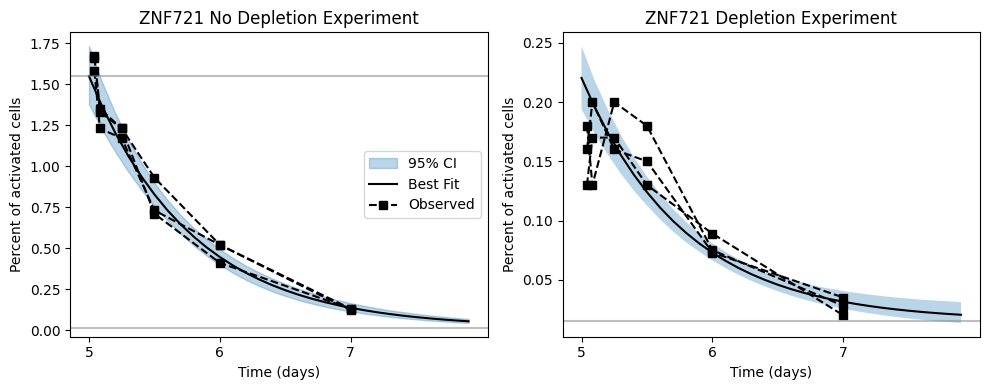

In [63]:
# Plot caluclated 95% confidence interval

# Format data
df_z = pd.DataFrame(
    posterior_simulations_z,
    columns=["group", "time", "y_d", "y_no_d"]
)

# group ids should be integers
df_z["group"] = df_z["group"].astype(int)

# Compute posterior summaries
summary = (
    df_z.groupby("time")
      .agg(
          y_no_d_lo=("y_no_d", lambda x: np.quantile(x, 0.025)),
          y_no_d_hi=("y_no_d", lambda x: np.quantile(x, 0.975)),
          y_d_lo=("y_d", lambda x: np.quantile(x, 0.025)),
          y_d_hi=("y_d", lambda x: np.quantile(x, 0.975)),
      )
      .reset_index()
)


# Make figure
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# ---- No Depletion Experiment ----
axes[0].fill_between(
    summary["time"],
    summary["y_no_d_lo"],
    summary["y_no_d_hi"],
    alpha=0.3,
    color="tab:blue",
    label="95% CI"
)

# Add mean trajectories:
sns.lineplot(data=average_traj_z, x="time", y= "y_no_d", color="black", ax = axes[0], label="Best Fit")

# Add observed data
for i in range(obs_data_no_d.shape[1]):
    axes[0].plot(
        day,
        obs_data_no_d[:,i]*100,
        color="black",
        marker="s",
        linestyle="--",
        label="Observed" if i == 0 else None
    )

# Add asymptotic fraction
axes[0].axhline(
    y=faw*100,
    color="gray",
    linestyle="-",
    linewidth=1.5,
    alpha=0.5
)

axes[0].axhline(
    y=fas*100,
    color="gray",
    linestyle="-",
    linewidth=1.5,
    alpha=0.5
)

axes[0].set_title("ZNF721 No Depletion Experiment")
axes[0].set_xlabel("Time (days)")
axes[0].set_ylabel("Percent of activated cells")
axes[0].legend()
axes[0].set_xticks((5,6,7))

# ---- Depletion Experiment ----
axes[1].fill_between(
    summary["time"],
    summary["y_d_lo"],
    summary["y_d_hi"],
    alpha=0.3,
    label="95% CI"
)

# Add mean trajectories:
sns.lineplot(data=average_traj_z, x="time", y= "y_d", color="black", ax = axes[1], label="Best Fit")

# Observed data
axes[1].plot(
    day,
    obs_data_deplete*100,
    color="black",
    marker="s",
    linestyle="--",
    label="Observed"
)

# Add asymptotic fraction
axes[1].axhline(
    y=faw*100,
    color="gray",
    linestyle="-",
    linewidth=1.5,
    alpha=0.5
)

axes[1].set_title("ZNF721 Depletion Experiment")
axes[1].set_xlabel("Time (days)")
axes[1].set_ylabel("Percent of activated cells")
axes[1].legend_ = None
axes[1].set_xticks((5,6,7))

plt.tight_layout()
plt.show()



#### Calculate fraction active at any time


In [64]:
# Simulate as ODE to calculate the cumulative activated cells
def model_cumulative(y,t,a,r):
    dy=[0,0,0]
    dy[0] = - a*y[0] + r*y[1] # latent cells
    dy[1] = a*y[0] - r*y[1] # reactivated cells
    dy[2] = a*y[0] # Cumulative activated cells
    return dy

tvec=np.arange(0,7,0.001)
cumulative_percent = np.zeros((len(indices), 1))

# Sample parameters and run simulation
z=0
for i in indices:
    # Sample parameters
    fa = trace_z.posterior.fas[0,i].item()
    r  = trace_z.posterior.r[0,i].item()
    a  = trace_z.posterior.a[0,i].item()

    # Simulate trajectories
    ic = [(1-fa), fa, fa]
    # ic = [(1-fa), fa, 0]
    soln=odeint(model_cumulative,ic,tvec,args=(a,r))
    p = soln[len(tvec)-1, 2]*100

    # Store results
    cumulative_percent[z] = p
    z=z+1

# Calculate mean and 95% HDI
hdi = az.hdi(cumulative_percent, hdi_prob=0.95)
mean = np.mean(cumulative_percent)

print("Percent of cells active at any point during 7 days is {:1.3f}%".format(mean))
print("Lower bound on Percent of cells active at any point during 7 days is {:1.3f}%".format(hdi[0][0]))
print("Upper bound on Percent of cells active at any point during 7 days is {:1.3f}%".format(hdi[0][1]))


Percent of cells active at any point during 7 days is 15.324%
Lower bound on Percent of cells active at any point during 7 days is 12.162%
Upper bound on Percent of cells active at any point during 7 days is 18.315%


/tmp/ipython-input-2659717750.py:31: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(cumulative_percent, hdi_prob=0.95)


### CTL killing simulations
We simulate CTL killing by allowing activated cells to die at a rate $d$, where 1/d is the average time cells live before they are killed by CTL:

Let $X$ = Number of resting cells, $Y$ = number of active cells

Differential equations (rate of change):

$\frac{dX}{dt} = - a X + r Y $

$\frac{dY}{dt} = a X - r Y - d Y$

We do not fit to data from experiments of ARC with CTL killing. Instead, we simulate the model with the estimated value of $a$ and $r$ from experiments without CTL killing, but assume a large rate of CTL killing ($d=10$, corresponding to cells living 0.1 days before dying).

In [65]:
## Plot the experimental data from CTL killing experiment
day = [1,5,7]

# Total number of cells without CTL
noCTL_total = np.zeros((3,2))
noCTL_total[:,0] = [6439.252336, 20878.04878, 86067.21698]
noCTL_total[:,1] = [5505.529226, 12517.41294, 154108.1751]

# Number of active cells without CTL
noCTL_HIV = np.zeros((3,2))
noCTL_HIV[:,0] = [158.8785047, 300.8130081, 858.8836478]
noCTL_HIV[:,1] = [63.19115324, 174.1293532, 1308.835673]

# Total number of cells with CTL
CTL_total = np.zeros((3,2))
CTL_total[:,0] = [5590.551181, 14596.12278, 5086.726998]
CTL_total[:,1] = [4161.7357, 9282.729805, 4468.426686]

# Number of active cells with CTL
CTL_HIV = np.zeros((3,2))
CTL_HIV[:,0] = [39.37007874, 48.46526656, 11.31221719]
CTL_HIV[:,1] = [59.17159763, 41.78272981, 26.75704602]


Text(0, 0.5, 'Percent activated cells')

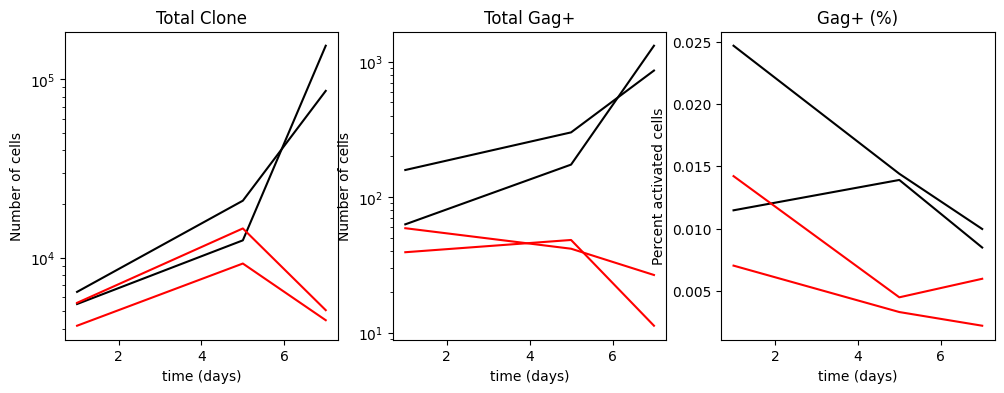

In [66]:
plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.plot(day, noCTL_total, color = 'black', label = "no CTL")
plt.plot(day, CTL_total, color = "red", label = "With CTL")
plt.yscale('log')
plt.title('Total Clone')
plt.xlabel("time (days)")
plt.ylabel('Number of cells')

plt.subplot(1,3,2)
plt.plot(day, noCTL_HIV, color = 'black', label = "no CTL")
plt.plot(day, CTL_HIV, color = "red", label = "With CTL")
plt.yscale('log')
plt.title('Total Gag+')
plt.xlabel("time (days)")
plt.ylabel('Number of cells')

plt.subplot(1,3,3)
plt.plot(day, noCTL_HIV/noCTL_total, color = 'black', label = "no CTL")
plt.plot(day, CTL_HIV/CTL_total, color = "red", label = "With CTL")
plt.title('Gag+ (%)')
plt.xlabel("time (days)")
plt.ylabel('Percent activated cells')

In [67]:
# Calculate relative difference for total cells
print((noCTL_total-CTL_total)/noCTL_total*100)

[[13.18011953 24.40807179]
 [30.08866425 25.84146701]
 [94.08982052 97.10046097]]


In [68]:
# Calculate relative difference for HIV+ cells
print((noCTL_HIV-CTL_HIV)/noCTL_HIV*100)

[[75.22000927  6.36094675]
 [83.88857355 76.00477516]
 [98.68291622 97.9556604 ]]


(0.0, 7.0)

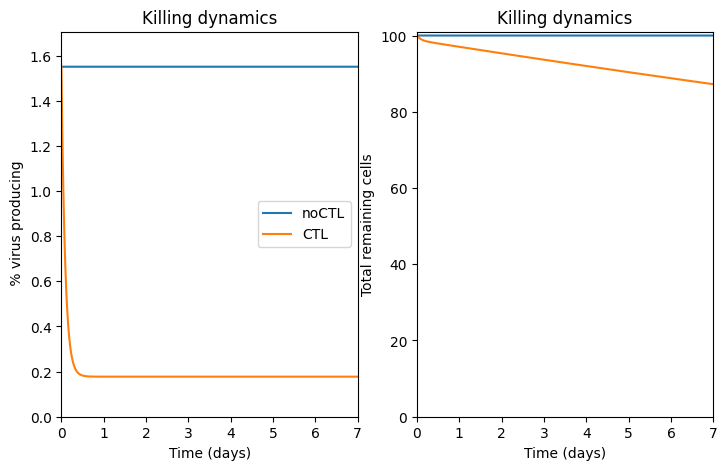

In [73]:
# Simulate scenario with mean parameters, comparing strong CTL to no CTL

def model_killing(y,t,a,r,d,b,aw):
    dy=[0,0,0]
    dy[0]= - a*y[0] + r*y[1]  # latent cells
    dy[1]= a*y[0] - (r+d)*y[1] # reactivated cells
    dy[2] = d*y[1] # cumulative cells that die from cytotoxic effects
    return dy

# Simulate 1 week
tmax=7

# Mean values
a = ZNF_summary.loc["a", "mean"]
aw = ZNF_summary.loc["a_w", "mean"]
r = ZNF_summary.loc["r", "mean"]
fa = a/(a+r)
d = 10 # CTL killing

tvec=np.arange(0,7,0.001)
ic = [1-fa, fa, 0]

soln_CTL=odeint(model_killing,ic,tvec,args=(a,r,d, b, aw))
soln_noCTL=odeint(model_killing,ic,tvec,args=(a,r,0,0, aw))

total_noCTL = 100*(soln_noCTL[:,0]+soln_noCTL[:,1])
total_CTL = 100*(soln_CTL[:,0]+soln_CTL[:,1])

HIV_noCTL = 100*(soln_noCTL[:,1])
HIV_CTL = 100*(soln_CTL[:,1])

perc_active_noCTL = 100*soln_noCTL[:,1]/(soln_noCTL[:,0]+soln_noCTL[:,1])
perc_active_CTL = 100*soln_CTL[:,1]/(soln_CTL[:,0]+soln_CTL[:,1])


# Plot
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.plot(tvec, perc_active_noCTL, label = "noCTL")
plt.plot(tvec, perc_active_CTL, label = "CTL")
plt.xlabel("Time (days)")
plt.ylabel(" % virus producing")
plt.title("Killing dynamics")
plt.ylim([0,100*fa*1.1])
plt.xlim([0,tmax])
plt.legend()

plt.subplot(1,3,2)
plt.plot(tvec, total_noCTL, label = "noCTL")
plt.plot(tvec, total_CTL, label = "CTL")
plt.xlabel("Time (days)")
plt.ylabel("Total remaining cells")
plt.title("Killing dynamics")
plt.ylim([0,101])
plt.xlim([0,tmax])




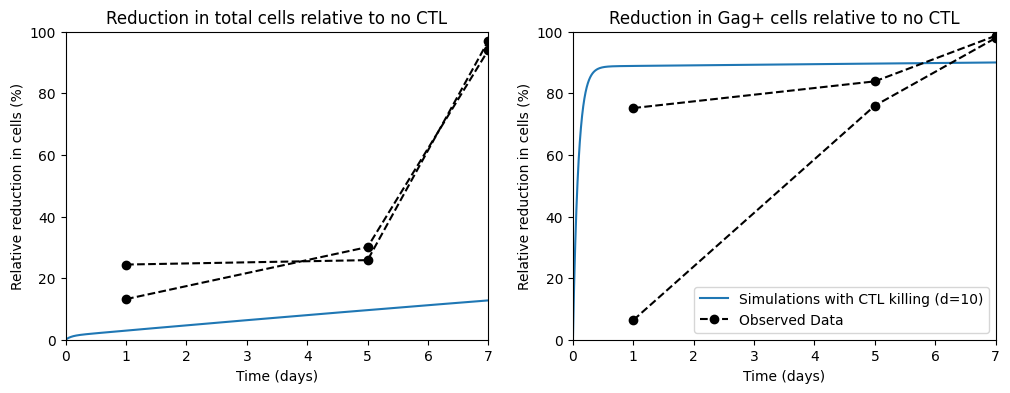

In [75]:
# Compare predictions with maximal CTL killing to experimental data

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(tvec, (total_noCTL-total_CTL)/total_noCTL*100)
plt.xlabel("Time (days)")
plt.ylabel("Relative reduction in cells (%)")
plt.title("Reduction in total cells relative to no CTL")
plt.ylim([0,100])
plt.xlim([0,tmax])
plt.plot(day, (noCTL_total-CTL_total)/noCTL_total*100, marker = 'o', ls = "--", color = "black")

plt.subplot(1,2,2)
plt.plot(tvec, (HIV_noCTL-HIV_CTL)/HIV_noCTL*100, label = "Simulations with CTL killing (d=10)")
plt.xlabel("Time (days)")
plt.ylabel("Relative reduction in cells (%)")
plt.title("Reduction in Gag+ cells relative to no CTL")
plt.ylim([0,100])
plt.xlim([0,tmax])
plt.plot(day, (noCTL_HIV[:,0]-CTL_HIV[:,0])/noCTL_HIV[:,0]*100, marker = 'o', ls = "--", color = "black", label = "Observed Data")
plt.plot(day, (noCTL_HIV[:,1]-CTL_HIV[:,1])/noCTL_HIV[:,1]*100, marker = 'o', ls = "--", color = "black")
plt.legend()